In [1]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

from keras.datasets.mnist import load_data

import numpy as np
from matplotlib import pyplot

In [2]:
# define discriminator

def define_discriminator(in_shape=(28, 28, 1)):
    
    model = Sequential(name='Discriminator')
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    optimizerr = Adam(lr=0.0002, beta_1 = 0.5)
    model.compile(loss='binary_crossentropy', optimizer = optimizerr, metrics=['accuracy'])
    
    return model

In [3]:
# define the standalone generator

def define_generator(latent_dim):
    gen = Sequential(name='Generator')
    
    # foundation for 7x7 image
    n_nodes = 7 * 7 * 128
    
    gen.add(Dense(n_nodes, input_dim=latent_dim))
    gen.add(Reshape((7, 7, 128)))
    
    # upsample to 14x14
    gen.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    gen.add(LeakyReLU(alpha=0.2))
    
    # upsample to 28x28
    gen.add(Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same'))
    gen.add(LeakyReLU(alpha=0.2))
    
    gen.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))
    
    return gen

In [4]:
# define gan

def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    
    # connect them
    gan = Sequential(name='GAN')
    
    gan.add(g_model)
    gan.add(d_model)
    
    # compile model
    opt = Adam(lr = 0.0002, beta_1 = 0.5)
    
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    
    return gan

In [5]:
# load mnist dataset

def get_mnist():
    (images, _), (_, _) = load_data()
    images = np.expand_dims(images, axis=-1)
    images = images.astype('float32')
    
    # scale from [0, 255] to [0, 1]
    images = images / 255.0
    
    return images

In [6]:
# select real samples

def generate_real_samples(dataset, n_samples):
    # choose random index of dataset
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    
    return X, y

In [7]:
# generate points in latent space as input for the generator

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape((n_samples, latent_dim))
    
    return x_input

In [8]:
# generate n fake samples with class labels

def generate_fake_samples(g_model, latent_dim, n_samples):
    
    X = generate_latent_points(latent_dim, n_samples)
    # reshape generated data into gray scale
    X = g_model.predict(X)
    # generate class labels for fake images
    y = np.zeros((n_samples, 1))
    
    return X, y

In [9]:
# summarize performance

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
     
        # prepare real samples
        X_real, y_real = generate_real_samples(dataset, n_samples)
        # evaluate discriminator on real samples
        _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
        
        # prepare fake samples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
        # evaluate discriminator on fake examples
        _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
        
        # summarize the discriminator performance
        print('\n>Acc for real sample: %.0f%%\nAcc for fake sample: %.0f%%' % (acc_real*100, acc_fake*100))
        
        # save the generator model file
        filename = 'generator_model_%03d.h5' % (epoch + 1)
        g_model.save(filename)

In [10]:
# train the discriminator

def trainGAN(g_model, d_model, gan, dataset, latent_dim, n_epochs=100, n_batch=256):
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch/2)
    
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            
            d_loss, _ = d_model.train_on_batch(X, y)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            
            # update the generator via the discriminator's error
            g_loss = gan.train_on_batch(X_gan, y_gan)
            
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss, g_loss))
            
        # evaluate the model performance sometimes
        if (i+1)%10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [11]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)

gan = define_gan(g_model, d_model)

# load image data
dataset = get_mnist()

d_model.summary()
g_model.summary()
gan.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

In [12]:
# train GAN
trainGAN(g_model, d_model, gan, dataset, latent_dim)

>1, 1/234, d=0.697, g=0.704
>1, 2/234, d=0.687, g=0.722
>1, 3/234, d=0.676, g=0.741
>1, 4/234, d=0.671, g=0.763
>1, 5/234, d=0.661, g=0.780
>1, 6/234, d=0.652, g=0.801
>1, 7/234, d=0.645, g=0.821
>1, 8/234, d=0.633, g=0.841
>1, 9/234, d=0.625, g=0.869
>1, 10/234, d=0.614, g=0.896
>1, 11/234, d=0.605, g=0.924
>1, 12/234, d=0.597, g=0.949
>1, 13/234, d=0.584, g=0.985
>1, 14/234, d=0.572, g=1.016
>1, 15/234, d=0.560, g=1.047
>1, 16/234, d=0.547, g=1.087
>1, 17/234, d=0.532, g=1.116
>1, 18/234, d=0.518, g=1.140
>1, 19/234, d=0.512, g=1.161
>1, 20/234, d=0.498, g=1.184
>1, 21/234, d=0.481, g=1.200
>1, 22/234, d=0.468, g=1.215
>1, 23/234, d=0.458, g=1.218
>1, 24/234, d=0.441, g=1.221
>1, 25/234, d=0.433, g=1.221
>1, 26/234, d=0.430, g=1.202
>1, 27/234, d=0.417, g=1.182
>1, 28/234, d=0.406, g=1.151
>1, 29/234, d=0.406, g=1.129
>1, 30/234, d=0.400, g=1.088
>1, 31/234, d=0.394, g=1.056
>1, 32/234, d=0.387, g=1.023
>1, 33/234, d=0.394, g=0.997
>1, 34/234, d=0.397, g=0.971
>1, 35/234, d=0.408, g=

>2, 48/234, d=0.537, g=1.023
>2, 49/234, d=0.584, g=0.890
>2, 50/234, d=0.612, g=0.922
>2, 51/234, d=0.534, g=1.052
>2, 52/234, d=0.539, g=0.923
>2, 53/234, d=0.569, g=0.846
>2, 54/234, d=0.599, g=0.904
>2, 55/234, d=0.563, g=1.009
>2, 56/234, d=0.575, g=0.895
>2, 57/234, d=0.606, g=1.021
>2, 58/234, d=0.528, g=0.929
>2, 59/234, d=0.639, g=1.026
>2, 60/234, d=0.599, g=0.837
>2, 61/234, d=0.609, g=1.090
>2, 62/234, d=0.581, g=0.967
>2, 63/234, d=0.602, g=0.787
>2, 64/234, d=0.583, g=0.916
>2, 65/234, d=0.592, g=1.032
>2, 66/234, d=0.581, g=0.939
>2, 67/234, d=0.579, g=0.957
>2, 68/234, d=0.607, g=0.840
>2, 69/234, d=0.616, g=1.060
>2, 70/234, d=0.568, g=0.991
>2, 71/234, d=0.617, g=0.977
>2, 72/234, d=0.583, g=0.936
>2, 73/234, d=0.587, g=0.920
>2, 74/234, d=0.604, g=0.885
>2, 75/234, d=0.613, g=0.980
>2, 76/234, d=0.636, g=0.881
>2, 77/234, d=0.605, g=0.959
>2, 78/234, d=0.610, g=1.021
>2, 79/234, d=0.603, g=0.983
>2, 80/234, d=0.640, g=0.776
>2, 81/234, d=0.664, g=1.126
>2, 82/234, d=

>3, 94/234, d=0.672, g=0.746
>3, 95/234, d=0.677, g=0.775
>3, 96/234, d=0.672, g=0.816
>3, 97/234, d=0.671, g=0.755
>3, 98/234, d=0.670, g=0.727
>3, 99/234, d=0.656, g=0.754
>3, 100/234, d=0.656, g=0.786
>3, 101/234, d=0.644, g=0.801
>3, 102/234, d=0.673, g=0.840
>3, 103/234, d=0.655, g=0.812
>3, 104/234, d=0.664, g=0.763
>3, 105/234, d=0.652, g=0.752
>3, 106/234, d=0.674, g=0.760
>3, 107/234, d=0.672, g=0.777
>3, 108/234, d=0.663, g=0.785
>3, 109/234, d=0.673, g=0.786
>3, 110/234, d=0.664, g=0.785
>3, 111/234, d=0.663, g=0.798
>3, 112/234, d=0.672, g=0.784
>3, 113/234, d=0.665, g=0.801
>3, 114/234, d=0.656, g=0.796
>3, 115/234, d=0.652, g=0.755
>3, 116/234, d=0.648, g=0.765
>3, 117/234, d=0.659, g=0.764
>3, 118/234, d=0.644, g=0.757
>3, 119/234, d=0.642, g=0.775
>3, 120/234, d=0.669, g=0.802
>3, 121/234, d=0.652, g=0.771
>3, 122/234, d=0.653, g=0.761
>3, 123/234, d=0.642, g=0.756
>3, 124/234, d=0.644, g=0.749
>3, 125/234, d=0.661, g=0.790
>3, 126/234, d=0.638, g=0.754
>3, 127/234, d=0

>4, 139/234, d=0.641, g=0.751
>4, 140/234, d=0.661, g=0.736
>4, 141/234, d=0.651, g=0.749
>4, 142/234, d=0.646, g=0.744
>4, 143/234, d=0.650, g=0.743
>4, 144/234, d=0.663, g=0.776
>4, 145/234, d=0.653, g=0.758
>4, 146/234, d=0.664, g=0.763
>4, 147/234, d=0.657, g=0.756
>4, 148/234, d=0.655, g=0.787
>4, 149/234, d=0.671, g=0.724
>4, 150/234, d=0.676, g=0.720
>4, 151/234, d=0.668, g=0.703
>4, 152/234, d=0.684, g=0.697
>4, 153/234, d=0.677, g=0.721
>4, 154/234, d=0.695, g=0.729
>4, 155/234, d=0.684, g=0.721
>4, 156/234, d=0.664, g=0.691
>4, 157/234, d=0.674, g=0.707
>4, 158/234, d=0.667, g=0.690
>4, 159/234, d=0.668, g=0.701
>4, 160/234, d=0.680, g=0.714
>4, 161/234, d=0.672, g=0.731
>4, 162/234, d=0.673, g=0.730
>4, 163/234, d=0.671, g=0.733
>4, 164/234, d=0.670, g=0.731
>4, 165/234, d=0.652, g=0.758
>4, 166/234, d=0.662, g=0.746
>4, 167/234, d=0.664, g=0.741
>4, 168/234, d=0.648, g=0.757
>4, 169/234, d=0.650, g=0.777
>4, 170/234, d=0.649, g=0.775
>4, 171/234, d=0.652, g=0.775
>4, 172/23

>5, 182/234, d=0.668, g=0.733
>5, 183/234, d=0.674, g=0.742
>5, 184/234, d=0.660, g=0.727
>5, 185/234, d=0.673, g=0.750
>5, 186/234, d=0.671, g=0.723
>5, 187/234, d=0.665, g=0.745
>5, 188/234, d=0.694, g=0.697
>5, 189/234, d=0.681, g=0.696
>5, 190/234, d=0.670, g=0.714
>5, 191/234, d=0.676, g=0.728
>5, 192/234, d=0.673, g=0.715
>5, 193/234, d=0.670, g=0.699
>5, 194/234, d=0.667, g=0.698
>5, 195/234, d=0.684, g=0.714
>5, 196/234, d=0.658, g=0.715
>5, 197/234, d=0.668, g=0.736
>5, 198/234, d=0.660, g=0.765
>5, 199/234, d=0.680, g=0.802
>5, 200/234, d=0.662, g=0.758
>5, 201/234, d=0.664, g=0.754
>5, 202/234, d=0.658, g=0.742
>5, 203/234, d=0.668, g=0.778
>5, 204/234, d=0.656, g=0.781
>5, 205/234, d=0.659, g=0.816
>5, 206/234, d=0.654, g=0.791
>5, 207/234, d=0.658, g=0.784
>5, 208/234, d=0.659, g=0.745
>5, 209/234, d=0.675, g=0.761
>5, 210/234, d=0.655, g=0.760
>5, 211/234, d=0.642, g=0.769
>5, 212/234, d=0.658, g=0.805
>5, 213/234, d=0.662, g=0.792
>5, 214/234, d=0.653, g=0.771
>5, 215/23

>6, 225/234, d=0.652, g=0.803
>6, 226/234, d=0.654, g=0.775
>6, 227/234, d=0.651, g=0.744
>6, 228/234, d=0.662, g=0.716
>6, 229/234, d=0.665, g=0.755
>6, 230/234, d=0.654, g=0.741
>6, 231/234, d=0.643, g=0.771
>6, 232/234, d=0.660, g=0.697
>6, 233/234, d=0.655, g=0.728
>6, 234/234, d=0.646, g=0.769
>7, 1/234, d=0.655, g=0.733
>7, 2/234, d=0.652, g=0.718
>7, 3/234, d=0.663, g=0.713
>7, 4/234, d=0.649, g=0.772
>7, 5/234, d=0.657, g=0.748
>7, 6/234, d=0.656, g=0.753
>7, 7/234, d=0.649, g=0.733
>7, 8/234, d=0.659, g=0.714
>7, 9/234, d=0.666, g=0.777
>7, 10/234, d=0.657, g=0.838
>7, 11/234, d=0.677, g=0.752
>7, 12/234, d=0.659, g=0.692
>7, 13/234, d=0.655, g=0.752
>7, 14/234, d=0.662, g=0.769
>7, 15/234, d=0.627, g=0.738
>7, 16/234, d=0.655, g=0.749
>7, 17/234, d=0.654, g=0.738
>7, 18/234, d=0.631, g=0.771
>7, 19/234, d=0.653, g=0.814
>7, 20/234, d=0.658, g=0.783
>7, 21/234, d=0.647, g=0.760
>7, 22/234, d=0.639, g=0.736
>7, 23/234, d=0.662, g=0.729
>7, 24/234, d=0.647, g=0.750
>7, 25/234, d

>8, 38/234, d=0.651, g=0.821
>8, 39/234, d=0.657, g=0.747
>8, 40/234, d=0.662, g=0.785
>8, 41/234, d=0.647, g=0.798
>8, 42/234, d=0.661, g=0.774
>8, 43/234, d=0.649, g=0.701
>8, 44/234, d=0.664, g=0.708
>8, 45/234, d=0.650, g=0.772
>8, 46/234, d=0.673, g=0.750
>8, 47/234, d=0.651, g=0.724
>8, 48/234, d=0.661, g=0.728
>8, 49/234, d=0.644, g=0.762
>8, 50/234, d=0.653, g=0.750
>8, 51/234, d=0.670, g=0.795
>8, 52/234, d=0.658, g=0.778
>8, 53/234, d=0.661, g=0.777
>8, 54/234, d=0.647, g=0.844
>8, 55/234, d=0.640, g=0.779
>8, 56/234, d=0.640, g=0.831
>8, 57/234, d=0.641, g=0.797
>8, 58/234, d=0.661, g=0.801
>8, 59/234, d=0.646, g=0.768
>8, 60/234, d=0.659, g=0.804
>8, 61/234, d=0.671, g=0.778
>8, 62/234, d=0.667, g=0.721
>8, 63/234, d=0.653, g=0.745
>8, 64/234, d=0.642, g=0.779
>8, 65/234, d=0.659, g=0.715
>8, 66/234, d=0.651, g=0.719
>8, 67/234, d=0.640, g=0.838
>8, 68/234, d=0.633, g=0.760
>8, 69/234, d=0.644, g=0.751
>8, 70/234, d=0.659, g=0.802
>8, 71/234, d=0.673, g=0.818
>8, 72/234, d=

>9, 84/234, d=0.675, g=0.829
>9, 85/234, d=0.663, g=0.822
>9, 86/234, d=0.629, g=0.842
>9, 87/234, d=0.627, g=0.842
>9, 88/234, d=0.651, g=0.788
>9, 89/234, d=0.633, g=0.742
>9, 90/234, d=0.643, g=0.746
>9, 91/234, d=0.668, g=0.751
>9, 92/234, d=0.668, g=0.712
>9, 93/234, d=0.662, g=0.676
>9, 94/234, d=0.662, g=0.711
>9, 95/234, d=0.676, g=0.733
>9, 96/234, d=0.642, g=0.789
>9, 97/234, d=0.665, g=0.820
>9, 98/234, d=0.657, g=0.765
>9, 99/234, d=0.624, g=0.766
>9, 100/234, d=0.648, g=0.863
>9, 101/234, d=0.657, g=0.752
>9, 102/234, d=0.646, g=0.791
>9, 103/234, d=0.648, g=0.931
>9, 104/234, d=0.671, g=0.775
>9, 105/234, d=0.659, g=0.751
>9, 106/234, d=0.659, g=0.864
>9, 107/234, d=0.661, g=0.782
>9, 108/234, d=0.664, g=0.691
>9, 109/234, d=0.666, g=0.750
>9, 110/234, d=0.677, g=0.801
>9, 111/234, d=0.659, g=0.686
>9, 112/234, d=0.663, g=0.753
>9, 113/234, d=0.657, g=0.741
>9, 114/234, d=0.679, g=0.728
>9, 115/234, d=0.674, g=0.814
>9, 116/234, d=0.649, g=0.751
>9, 117/234, d=0.678, g=0.

>10, 126/234, d=0.633, g=0.799
>10, 127/234, d=0.653, g=0.771
>10, 128/234, d=0.648, g=0.759
>10, 129/234, d=0.630, g=0.746
>10, 130/234, d=0.669, g=0.748
>10, 131/234, d=0.677, g=0.770
>10, 132/234, d=0.669, g=0.792
>10, 133/234, d=0.692, g=0.771
>10, 134/234, d=0.658, g=0.730
>10, 135/234, d=0.661, g=0.801
>10, 136/234, d=0.689, g=0.738
>10, 137/234, d=0.667, g=0.760
>10, 138/234, d=0.671, g=0.730
>10, 139/234, d=0.655, g=0.785
>10, 140/234, d=0.675, g=0.706
>10, 141/234, d=0.666, g=0.805
>10, 142/234, d=0.654, g=0.730
>10, 143/234, d=0.668, g=0.756
>10, 144/234, d=0.661, g=0.791
>10, 145/234, d=0.641, g=0.826
>10, 146/234, d=0.655, g=0.786
>10, 147/234, d=0.666, g=0.756
>10, 148/234, d=0.656, g=0.769
>10, 149/234, d=0.639, g=0.795
>10, 150/234, d=0.658, g=0.740
>10, 151/234, d=0.669, g=0.844
>10, 152/234, d=0.671, g=0.750
>10, 153/234, d=0.665, g=0.763
>10, 154/234, d=0.666, g=0.745
>10, 155/234, d=0.671, g=0.729
>10, 156/234, d=0.658, g=0.740
>10, 157/234, d=0.669, g=0.800
>10, 158

>11, 160/234, d=0.642, g=0.801
>11, 161/234, d=0.673, g=0.722
>11, 162/234, d=0.650, g=0.748
>11, 163/234, d=0.663, g=0.813
>11, 164/234, d=0.668, g=0.755
>11, 165/234, d=0.652, g=0.707
>11, 166/234, d=0.653, g=0.793
>11, 167/234, d=0.667, g=0.784
>11, 168/234, d=0.651, g=0.786
>11, 169/234, d=0.650, g=0.744
>11, 170/234, d=0.655, g=0.797
>11, 171/234, d=0.668, g=0.825
>11, 172/234, d=0.658, g=0.800
>11, 173/234, d=0.654, g=0.822
>11, 174/234, d=0.657, g=0.732
>11, 175/234, d=0.691, g=0.719
>11, 176/234, d=0.651, g=0.783
>11, 177/234, d=0.659, g=0.691
>11, 178/234, d=0.655, g=0.684
>11, 179/234, d=0.663, g=0.694
>11, 180/234, d=0.662, g=0.780
>11, 181/234, d=0.662, g=0.776
>11, 182/234, d=0.655, g=0.763
>11, 183/234, d=0.663, g=0.760
>11, 184/234, d=0.649, g=0.747
>11, 185/234, d=0.648, g=0.783
>11, 186/234, d=0.677, g=0.806
>11, 187/234, d=0.656, g=0.793
>11, 188/234, d=0.645, g=0.847
>11, 189/234, d=0.658, g=0.749
>11, 190/234, d=0.644, g=0.781
>11, 191/234, d=0.647, g=0.727
>11, 192

>12, 195/234, d=0.648, g=0.783
>12, 196/234, d=0.655, g=0.836
>12, 197/234, d=0.658, g=0.795
>12, 198/234, d=0.671, g=0.816
>12, 199/234, d=0.664, g=0.784
>12, 200/234, d=0.667, g=0.804
>12, 201/234, d=0.677, g=0.788
>12, 202/234, d=0.646, g=0.794
>12, 203/234, d=0.671, g=0.757
>12, 204/234, d=0.636, g=0.757
>12, 205/234, d=0.660, g=0.746
>12, 206/234, d=0.667, g=0.756
>12, 207/234, d=0.668, g=0.723
>12, 208/234, d=0.644, g=0.739
>12, 209/234, d=0.650, g=0.795
>12, 210/234, d=0.665, g=0.788
>12, 211/234, d=0.664, g=0.747
>12, 212/234, d=0.658, g=0.740
>12, 213/234, d=0.660, g=0.863
>12, 214/234, d=0.664, g=0.806
>12, 215/234, d=0.668, g=0.766
>12, 216/234, d=0.663, g=0.820
>12, 217/234, d=0.666, g=0.760
>12, 218/234, d=0.666, g=0.691
>12, 219/234, d=0.653, g=0.770
>12, 220/234, d=0.652, g=0.776
>12, 221/234, d=0.640, g=0.755
>12, 222/234, d=0.650, g=0.761
>12, 223/234, d=0.654, g=0.785
>12, 224/234, d=0.652, g=0.739
>12, 225/234, d=0.645, g=0.773
>12, 226/234, d=0.675, g=0.837
>12, 227

>13, 229/234, d=0.654, g=0.749
>13, 230/234, d=0.643, g=0.768
>13, 231/234, d=0.675, g=0.821
>13, 232/234, d=0.681, g=0.735
>13, 233/234, d=0.650, g=0.798
>13, 234/234, d=0.670, g=0.893
>14, 1/234, d=0.665, g=0.718
>14, 2/234, d=0.667, g=0.775
>14, 3/234, d=0.665, g=0.851
>14, 4/234, d=0.656, g=0.769
>14, 5/234, d=0.640, g=0.740
>14, 6/234, d=0.663, g=0.703
>14, 7/234, d=0.654, g=0.706
>14, 8/234, d=0.653, g=0.721
>14, 9/234, d=0.641, g=0.756
>14, 10/234, d=0.651, g=0.757
>14, 11/234, d=0.660, g=0.813
>14, 12/234, d=0.637, g=0.793
>14, 13/234, d=0.682, g=0.803
>14, 14/234, d=0.667, g=0.780
>14, 15/234, d=0.676, g=0.826
>14, 16/234, d=0.674, g=0.822
>14, 17/234, d=0.659, g=0.759
>14, 18/234, d=0.676, g=0.861
>14, 19/234, d=0.653, g=0.862
>14, 20/234, d=0.684, g=0.721
>14, 21/234, d=0.674, g=0.725
>14, 22/234, d=0.679, g=0.794
>14, 23/234, d=0.668, g=0.726
>14, 24/234, d=0.660, g=0.680
>14, 25/234, d=0.666, g=0.722
>14, 26/234, d=0.666, g=0.862
>14, 27/234, d=0.647, g=0.764
>14, 28/234, 

>15, 32/234, d=0.653, g=0.753
>15, 33/234, d=0.644, g=0.745
>15, 34/234, d=0.662, g=0.743
>15, 35/234, d=0.650, g=0.725
>15, 36/234, d=0.664, g=0.772
>15, 37/234, d=0.656, g=0.802
>15, 38/234, d=0.641, g=0.675
>15, 39/234, d=0.664, g=0.803
>15, 40/234, d=0.671, g=0.849
>15, 41/234, d=0.652, g=0.769
>15, 42/234, d=0.653, g=0.735
>15, 43/234, d=0.669, g=0.807
>15, 44/234, d=0.687, g=0.749
>15, 45/234, d=0.658, g=0.770
>15, 46/234, d=0.652, g=0.725
>15, 47/234, d=0.647, g=0.768
>15, 48/234, d=0.673, g=0.757
>15, 49/234, d=0.643, g=0.716
>15, 50/234, d=0.650, g=0.799
>15, 51/234, d=0.656, g=0.809
>15, 52/234, d=0.670, g=0.776
>15, 53/234, d=0.638, g=0.753
>15, 54/234, d=0.656, g=0.841
>15, 55/234, d=0.681, g=0.759
>15, 56/234, d=0.656, g=0.794
>15, 57/234, d=0.636, g=0.764
>15, 58/234, d=0.655, g=0.735
>15, 59/234, d=0.652, g=0.732
>15, 60/234, d=0.660, g=0.749
>15, 61/234, d=0.661, g=0.709
>15, 62/234, d=0.668, g=0.775
>15, 63/234, d=0.672, g=0.777
>15, 64/234, d=0.646, g=0.767
>15, 65/23

>16, 68/234, d=0.666, g=0.807
>16, 69/234, d=0.657, g=0.855
>16, 70/234, d=0.643, g=0.727
>16, 71/234, d=0.644, g=0.733
>16, 72/234, d=0.646, g=0.897
>16, 73/234, d=0.675, g=0.750
>16, 74/234, d=0.654, g=0.685
>16, 75/234, d=0.670, g=0.746
>16, 76/234, d=0.679, g=0.720
>16, 77/234, d=0.674, g=0.686
>16, 78/234, d=0.681, g=0.769
>16, 79/234, d=0.647, g=0.804
>16, 80/234, d=0.648, g=0.745
>16, 81/234, d=0.667, g=0.772
>16, 82/234, d=0.654, g=0.811
>16, 83/234, d=0.651, g=0.783
>16, 84/234, d=0.644, g=0.774
>16, 85/234, d=0.647, g=0.752
>16, 86/234, d=0.660, g=0.914
>16, 87/234, d=0.644, g=0.736
>16, 88/234, d=0.667, g=0.788
>16, 89/234, d=0.655, g=0.838
>16, 90/234, d=0.661, g=0.787
>16, 91/234, d=0.644, g=0.760
>16, 92/234, d=0.669, g=0.707
>16, 93/234, d=0.669, g=0.721
>16, 94/234, d=0.673, g=0.719
>16, 95/234, d=0.646, g=0.720
>16, 96/234, d=0.663, g=0.712
>16, 97/234, d=0.666, g=0.785
>16, 98/234, d=0.667, g=0.780
>16, 99/234, d=0.678, g=0.815
>16, 100/234, d=0.678, g=0.820
>16, 101/

>17, 104/234, d=0.683, g=0.794
>17, 105/234, d=0.674, g=0.842
>17, 106/234, d=0.658, g=0.762
>17, 107/234, d=0.644, g=0.766
>17, 108/234, d=0.688, g=0.819
>17, 109/234, d=0.652, g=0.782
>17, 110/234, d=0.647, g=0.743
>17, 111/234, d=0.644, g=0.751
>17, 112/234, d=0.675, g=0.763
>17, 113/234, d=0.658, g=0.756
>17, 114/234, d=0.676, g=0.713
>17, 115/234, d=0.661, g=0.733
>17, 116/234, d=0.681, g=0.715
>17, 117/234, d=0.653, g=0.719
>17, 118/234, d=0.660, g=0.787
>17, 119/234, d=0.684, g=0.755
>17, 120/234, d=0.668, g=0.807
>17, 121/234, d=0.676, g=0.790
>17, 122/234, d=0.663, g=0.824
>17, 123/234, d=0.673, g=0.764
>17, 124/234, d=0.665, g=0.746
>17, 125/234, d=0.668, g=0.847
>17, 126/234, d=0.664, g=0.787
>17, 127/234, d=0.655, g=0.727
>17, 128/234, d=0.655, g=0.736
>17, 129/234, d=0.641, g=0.784
>17, 130/234, d=0.661, g=0.803
>17, 131/234, d=0.663, g=0.691
>17, 132/234, d=0.642, g=0.764
>17, 133/234, d=0.669, g=0.794
>17, 134/234, d=0.669, g=0.780
>17, 135/234, d=0.688, g=0.800
>17, 136

>18, 139/234, d=0.655, g=0.834
>18, 140/234, d=0.656, g=0.815
>18, 141/234, d=0.651, g=0.754
>18, 142/234, d=0.676, g=0.732
>18, 143/234, d=0.670, g=0.781
>18, 144/234, d=0.672, g=0.738
>18, 145/234, d=0.659, g=0.794
>18, 146/234, d=0.660, g=0.740
>18, 147/234, d=0.635, g=0.725
>18, 148/234, d=0.671, g=0.789
>18, 149/234, d=0.694, g=0.785
>18, 150/234, d=0.653, g=0.736
>18, 151/234, d=0.674, g=0.795
>18, 152/234, d=0.665, g=0.836
>18, 153/234, d=0.687, g=0.778
>18, 154/234, d=0.665, g=0.717
>18, 155/234, d=0.657, g=0.796
>18, 156/234, d=0.665, g=0.866
>18, 157/234, d=0.662, g=0.782
>18, 158/234, d=0.652, g=0.736
>18, 159/234, d=0.641, g=0.789
>18, 160/234, d=0.681, g=0.735
>18, 161/234, d=0.667, g=0.747
>18, 162/234, d=0.654, g=0.744
>18, 163/234, d=0.651, g=0.788
>18, 164/234, d=0.671, g=0.720
>18, 165/234, d=0.684, g=0.834
>18, 166/234, d=0.678, g=0.757
>18, 167/234, d=0.639, g=0.759
>18, 168/234, d=0.659, g=0.806
>18, 169/234, d=0.686, g=0.742
>18, 170/234, d=0.664, g=0.779
>18, 171

>19, 175/234, d=0.680, g=0.763
>19, 176/234, d=0.670, g=0.754
>19, 177/234, d=0.651, g=0.738
>19, 178/234, d=0.679, g=0.817
>19, 179/234, d=0.662, g=0.738
>19, 180/234, d=0.671, g=0.812
>19, 181/234, d=0.650, g=0.829
>19, 182/234, d=0.665, g=0.748
>19, 183/234, d=0.670, g=0.731
>19, 184/234, d=0.653, g=0.782
>19, 185/234, d=0.679, g=0.757
>19, 186/234, d=0.657, g=0.792
>19, 187/234, d=0.665, g=0.744
>19, 188/234, d=0.664, g=0.724
>19, 189/234, d=0.645, g=0.758
>19, 190/234, d=0.657, g=0.781
>19, 191/234, d=0.649, g=0.804
>19, 192/234, d=0.656, g=0.699
>19, 193/234, d=0.675, g=0.795
>19, 194/234, d=0.674, g=0.810
>19, 195/234, d=0.649, g=0.783
>19, 196/234, d=0.665, g=0.734
>19, 197/234, d=0.670, g=0.766
>19, 198/234, d=0.654, g=0.757
>19, 199/234, d=0.663, g=0.833
>19, 200/234, d=0.658, g=0.705
>19, 201/234, d=0.671, g=0.740
>19, 202/234, d=0.668, g=0.826
>19, 203/234, d=0.677, g=0.779
>19, 204/234, d=0.669, g=0.672
>19, 205/234, d=0.651, g=0.740
>19, 206/234, d=0.664, g=0.776
>19, 207

>20, 210/234, d=0.660, g=0.826
>20, 211/234, d=0.705, g=0.817
>20, 212/234, d=0.684, g=0.799
>20, 213/234, d=0.661, g=0.815
>20, 214/234, d=0.652, g=0.836
>20, 215/234, d=0.655, g=0.762
>20, 216/234, d=0.676, g=0.727
>20, 217/234, d=0.674, g=0.665
>20, 218/234, d=0.653, g=0.782
>20, 219/234, d=0.669, g=0.798
>20, 220/234, d=0.660, g=0.714
>20, 221/234, d=0.661, g=0.712
>20, 222/234, d=0.672, g=0.808
>20, 223/234, d=0.657, g=0.751
>20, 224/234, d=0.654, g=0.709
>20, 225/234, d=0.656, g=0.759
>20, 226/234, d=0.666, g=0.887
>20, 227/234, d=0.645, g=0.814
>20, 228/234, d=0.660, g=0.818
>20, 229/234, d=0.673, g=0.741
>20, 230/234, d=0.664, g=0.807
>20, 231/234, d=0.670, g=0.811
>20, 232/234, d=0.666, g=0.706
>20, 233/234, d=0.687, g=0.664
>20, 234/234, d=0.681, g=0.763

>Acc for real sample: 71%
Acc for fake sample: 82%
>21, 1/234, d=0.654, g=0.773
>21, 2/234, d=0.668, g=0.759
>21, 3/234, d=0.665, g=0.720
>21, 4/234, d=0.678, g=0.806
>21, 5/234, d=0.662, g=0.817
>21, 6/234, d=0.661, g=0.773

>22, 10/234, d=0.682, g=0.720
>22, 11/234, d=0.662, g=0.762
>22, 12/234, d=0.654, g=0.817
>22, 13/234, d=0.666, g=0.825
>22, 14/234, d=0.666, g=0.830
>22, 15/234, d=0.661, g=0.800
>22, 16/234, d=0.651, g=0.779
>22, 17/234, d=0.650, g=0.692
>22, 18/234, d=0.657, g=0.776
>22, 19/234, d=0.672, g=0.733
>22, 20/234, d=0.651, g=0.752
>22, 21/234, d=0.662, g=0.831
>22, 22/234, d=0.654, g=0.739
>22, 23/234, d=0.671, g=0.750
>22, 24/234, d=0.657, g=0.855
>22, 25/234, d=0.670, g=0.706
>22, 26/234, d=0.665, g=0.757
>22, 27/234, d=0.646, g=0.828
>22, 28/234, d=0.654, g=0.850
>22, 29/234, d=0.651, g=0.711
>22, 30/234, d=0.639, g=0.706
>22, 31/234, d=0.675, g=0.809
>22, 32/234, d=0.667, g=0.795
>22, 33/234, d=0.678, g=0.779
>22, 34/234, d=0.654, g=0.750
>22, 35/234, d=0.660, g=0.753
>22, 36/234, d=0.664, g=0.767
>22, 37/234, d=0.658, g=0.755
>22, 38/234, d=0.671, g=0.769
>22, 39/234, d=0.665, g=0.720
>22, 40/234, d=0.662, g=0.769
>22, 41/234, d=0.671, g=0.756
>22, 42/234, d=0.656, g=0.831
>22, 43/23

>23, 46/234, d=0.670, g=0.777
>23, 47/234, d=0.655, g=0.702
>23, 48/234, d=0.666, g=0.712
>23, 49/234, d=0.668, g=0.818
>23, 50/234, d=0.648, g=0.769
>23, 51/234, d=0.651, g=0.735
>23, 52/234, d=0.665, g=0.771
>23, 53/234, d=0.637, g=0.756
>23, 54/234, d=0.646, g=0.761
>23, 55/234, d=0.655, g=0.772
>23, 56/234, d=0.675, g=0.780
>23, 57/234, d=0.662, g=0.751
>23, 58/234, d=0.675, g=0.808
>23, 59/234, d=0.655, g=0.778
>23, 60/234, d=0.651, g=0.800
>23, 61/234, d=0.683, g=0.713
>23, 62/234, d=0.642, g=0.749
>23, 63/234, d=0.646, g=0.831
>23, 64/234, d=0.680, g=0.786
>23, 65/234, d=0.667, g=0.804
>23, 66/234, d=0.666, g=0.712
>23, 67/234, d=0.650, g=0.756
>23, 68/234, d=0.667, g=0.778
>23, 69/234, d=0.668, g=0.781
>23, 70/234, d=0.672, g=0.752
>23, 71/234, d=0.661, g=0.803
>23, 72/234, d=0.653, g=0.732
>23, 73/234, d=0.666, g=0.806
>23, 74/234, d=0.647, g=0.737
>23, 75/234, d=0.659, g=0.755
>23, 76/234, d=0.663, g=0.722
>23, 77/234, d=0.666, g=0.815
>23, 78/234, d=0.664, g=0.798
>23, 79/23

>24, 82/234, d=0.637, g=0.767
>24, 83/234, d=0.654, g=0.737
>24, 84/234, d=0.667, g=0.796
>24, 85/234, d=0.652, g=0.757
>24, 86/234, d=0.631, g=0.808
>24, 87/234, d=0.687, g=0.787
>24, 88/234, d=0.675, g=0.803
>24, 89/234, d=0.656, g=0.785
>24, 90/234, d=0.659, g=0.775
>24, 91/234, d=0.651, g=0.817
>24, 92/234, d=0.681, g=0.788
>24, 93/234, d=0.669, g=0.796
>24, 94/234, d=0.675, g=0.764
>24, 95/234, d=0.642, g=0.777
>24, 96/234, d=0.649, g=0.723
>24, 97/234, d=0.676, g=0.789
>24, 98/234, d=0.665, g=0.789
>24, 99/234, d=0.653, g=0.809
>24, 100/234, d=0.656, g=0.799
>24, 101/234, d=0.665, g=0.696
>24, 102/234, d=0.667, g=0.791
>24, 103/234, d=0.677, g=0.793
>24, 104/234, d=0.684, g=0.805
>24, 105/234, d=0.672, g=0.786
>24, 106/234, d=0.660, g=0.712
>24, 107/234, d=0.653, g=0.747
>24, 108/234, d=0.659, g=0.855
>24, 109/234, d=0.654, g=0.721
>24, 110/234, d=0.654, g=0.729
>24, 111/234, d=0.660, g=0.787
>24, 112/234, d=0.673, g=0.811
>24, 113/234, d=0.653, g=0.759
>24, 114/234, d=0.645, g=0

>25, 117/234, d=0.644, g=0.788
>25, 118/234, d=0.667, g=0.763
>25, 119/234, d=0.681, g=0.798
>25, 120/234, d=0.639, g=0.771
>25, 121/234, d=0.678, g=0.860
>25, 122/234, d=0.655, g=0.703
>25, 123/234, d=0.664, g=0.790
>25, 124/234, d=0.644, g=0.830
>25, 125/234, d=0.653, g=0.787
>25, 126/234, d=0.663, g=0.792
>25, 127/234, d=0.651, g=0.723
>25, 128/234, d=0.645, g=0.785
>25, 129/234, d=0.646, g=0.758
>25, 130/234, d=0.633, g=0.688
>25, 131/234, d=0.686, g=0.769
>25, 132/234, d=0.651, g=0.762
>25, 133/234, d=0.626, g=0.762
>25, 134/234, d=0.677, g=0.785
>25, 135/234, d=0.653, g=0.768
>25, 136/234, d=0.651, g=0.778
>25, 137/234, d=0.651, g=0.741
>25, 138/234, d=0.646, g=0.823
>25, 139/234, d=0.666, g=0.862
>25, 140/234, d=0.674, g=0.703
>25, 141/234, d=0.660, g=0.798
>25, 142/234, d=0.657, g=0.761
>25, 143/234, d=0.643, g=0.815
>25, 144/234, d=0.663, g=0.714
>25, 145/234, d=0.677, g=0.711
>25, 146/234, d=0.651, g=0.761
>25, 147/234, d=0.653, g=0.776
>25, 148/234, d=0.664, g=0.789
>25, 149

>26, 151/234, d=0.661, g=0.694
>26, 152/234, d=0.647, g=0.741
>26, 153/234, d=0.670, g=0.762
>26, 154/234, d=0.638, g=0.809
>26, 155/234, d=0.667, g=0.727
>26, 156/234, d=0.639, g=0.728
>26, 157/234, d=0.648, g=0.809
>26, 158/234, d=0.664, g=0.808
>26, 159/234, d=0.670, g=0.782
>26, 160/234, d=0.640, g=0.681
>26, 161/234, d=0.672, g=0.763
>26, 162/234, d=0.673, g=0.849
>26, 163/234, d=0.670, g=0.736
>26, 164/234, d=0.659, g=0.755
>26, 165/234, d=0.670, g=0.759
>26, 166/234, d=0.663, g=0.804
>26, 167/234, d=0.663, g=0.750
>26, 168/234, d=0.658, g=0.753
>26, 169/234, d=0.659, g=0.760
>26, 170/234, d=0.645, g=0.796
>26, 171/234, d=0.649, g=0.785
>26, 172/234, d=0.649, g=0.779
>26, 173/234, d=0.649, g=0.812
>26, 174/234, d=0.658, g=0.802
>26, 175/234, d=0.657, g=0.706
>26, 176/234, d=0.690, g=0.817
>26, 177/234, d=0.655, g=0.847
>26, 178/234, d=0.665, g=0.684
>26, 179/234, d=0.660, g=0.766
>26, 180/234, d=0.671, g=0.839
>26, 181/234, d=0.666, g=0.761
>26, 182/234, d=0.664, g=0.751
>26, 183

>27, 186/234, d=0.674, g=0.815
>27, 187/234, d=0.660, g=0.785
>27, 188/234, d=0.673, g=0.749
>27, 189/234, d=0.667, g=0.713
>27, 190/234, d=0.645, g=0.920
>27, 191/234, d=0.692, g=0.735
>27, 192/234, d=0.653, g=0.758
>27, 193/234, d=0.653, g=0.883
>27, 194/234, d=0.673, g=0.782
>27, 195/234, d=0.636, g=0.731
>27, 196/234, d=0.672, g=0.792
>27, 197/234, d=0.657, g=0.825
>27, 198/234, d=0.679, g=0.741
>27, 199/234, d=0.676, g=0.772
>27, 200/234, d=0.676, g=0.838
>27, 201/234, d=0.674, g=0.738
>27, 202/234, d=0.657, g=0.806
>27, 203/234, d=0.646, g=0.743
>27, 204/234, d=0.663, g=0.817
>27, 205/234, d=0.650, g=0.728
>27, 206/234, d=0.659, g=0.736
>27, 207/234, d=0.691, g=0.801
>27, 208/234, d=0.657, g=0.781
>27, 209/234, d=0.666, g=0.743
>27, 210/234, d=0.655, g=0.714
>27, 211/234, d=0.667, g=0.770
>27, 212/234, d=0.662, g=0.786
>27, 213/234, d=0.654, g=0.803
>27, 214/234, d=0.638, g=0.709
>27, 215/234, d=0.657, g=0.717
>27, 216/234, d=0.674, g=0.841
>27, 217/234, d=0.661, g=0.796
>27, 218

>28, 220/234, d=0.666, g=0.751
>28, 221/234, d=0.663, g=0.791
>28, 222/234, d=0.675, g=0.798
>28, 223/234, d=0.668, g=0.838
>28, 224/234, d=0.647, g=0.762
>28, 225/234, d=0.674, g=0.831
>28, 226/234, d=0.655, g=0.781
>28, 227/234, d=0.646, g=0.745
>28, 228/234, d=0.663, g=0.782
>28, 229/234, d=0.646, g=0.781
>28, 230/234, d=0.661, g=0.744
>28, 231/234, d=0.665, g=0.772
>28, 232/234, d=0.641, g=0.809
>28, 233/234, d=0.651, g=0.778
>28, 234/234, d=0.658, g=0.688
>29, 1/234, d=0.660, g=0.790
>29, 2/234, d=0.650, g=0.777
>29, 3/234, d=0.653, g=0.768
>29, 4/234, d=0.655, g=0.743
>29, 5/234, d=0.651, g=0.763
>29, 6/234, d=0.669, g=0.856
>29, 7/234, d=0.668, g=0.763
>29, 8/234, d=0.675, g=0.778
>29, 9/234, d=0.653, g=0.833
>29, 10/234, d=0.654, g=0.710
>29, 11/234, d=0.664, g=0.757
>29, 12/234, d=0.646, g=0.892
>29, 13/234, d=0.661, g=0.721
>29, 14/234, d=0.668, g=0.716
>29, 15/234, d=0.656, g=0.786
>29, 16/234, d=0.684, g=0.781
>29, 17/234, d=0.663, g=0.792
>29, 18/234, d=0.674, g=0.741
>29,

>30, 21/234, d=0.642, g=0.807
>30, 22/234, d=0.654, g=0.721
>30, 23/234, d=0.685, g=0.743
>30, 24/234, d=0.674, g=0.847
>30, 25/234, d=0.655, g=0.766
>30, 26/234, d=0.680, g=0.736
>30, 27/234, d=0.666, g=0.796
>30, 28/234, d=0.673, g=0.768
>30, 29/234, d=0.680, g=0.791
>30, 30/234, d=0.639, g=0.777
>30, 31/234, d=0.669, g=0.821
>30, 32/234, d=0.664, g=0.799
>30, 33/234, d=0.664, g=0.761
>30, 34/234, d=0.661, g=0.861
>30, 35/234, d=0.666, g=0.793
>30, 36/234, d=0.656, g=0.754
>30, 37/234, d=0.668, g=0.744
>30, 38/234, d=0.659, g=0.776
>30, 39/234, d=0.669, g=0.795
>30, 40/234, d=0.650, g=0.801
>30, 41/234, d=0.683, g=0.808
>30, 42/234, d=0.657, g=0.820
>30, 43/234, d=0.670, g=0.833
>30, 44/234, d=0.661, g=0.815
>30, 45/234, d=0.665, g=0.796
>30, 46/234, d=0.655, g=0.745
>30, 47/234, d=0.660, g=0.766
>30, 48/234, d=0.663, g=0.776
>30, 49/234, d=0.658, g=0.780
>30, 50/234, d=0.658, g=0.756
>30, 51/234, d=0.660, g=0.710
>30, 52/234, d=0.667, g=0.806
>30, 53/234, d=0.648, g=0.773
>30, 54/23

>31, 56/234, d=0.637, g=0.772
>31, 57/234, d=0.666, g=0.718
>31, 58/234, d=0.670, g=0.794
>31, 59/234, d=0.650, g=0.783
>31, 60/234, d=0.640, g=0.829
>31, 61/234, d=0.648, g=0.771
>31, 62/234, d=0.672, g=0.769
>31, 63/234, d=0.632, g=0.745
>31, 64/234, d=0.667, g=0.796
>31, 65/234, d=0.661, g=0.772
>31, 66/234, d=0.676, g=0.711
>31, 67/234, d=0.664, g=0.820
>31, 68/234, d=0.646, g=0.762
>31, 69/234, d=0.653, g=0.700
>31, 70/234, d=0.662, g=0.789
>31, 71/234, d=0.675, g=0.757
>31, 72/234, d=0.650, g=0.753
>31, 73/234, d=0.632, g=0.823
>31, 74/234, d=0.666, g=0.831
>31, 75/234, d=0.635, g=0.759
>31, 76/234, d=0.659, g=0.760
>31, 77/234, d=0.662, g=0.753
>31, 78/234, d=0.635, g=0.755
>31, 79/234, d=0.677, g=0.795
>31, 80/234, d=0.687, g=0.831
>31, 81/234, d=0.678, g=0.807
>31, 82/234, d=0.672, g=0.792
>31, 83/234, d=0.645, g=0.777
>31, 84/234, d=0.639, g=0.836
>31, 85/234, d=0.654, g=0.794
>31, 86/234, d=0.654, g=0.766
>31, 87/234, d=0.643, g=0.764
>31, 88/234, d=0.654, g=0.846
>31, 89/23

>32, 92/234, d=0.671, g=0.734
>32, 93/234, d=0.651, g=0.803
>32, 94/234, d=0.655, g=0.727
>32, 95/234, d=0.667, g=0.765
>32, 96/234, d=0.664, g=0.837
>32, 97/234, d=0.665, g=0.746
>32, 98/234, d=0.644, g=0.781
>32, 99/234, d=0.660, g=0.869
>32, 100/234, d=0.651, g=0.718
>32, 101/234, d=0.650, g=0.789
>32, 102/234, d=0.661, g=0.810
>32, 103/234, d=0.650, g=0.837
>32, 104/234, d=0.665, g=0.750
>32, 105/234, d=0.650, g=0.803
>32, 106/234, d=0.671, g=0.792
>32, 107/234, d=0.654, g=0.727
>32, 108/234, d=0.670, g=0.802
>32, 109/234, d=0.652, g=0.784
>32, 110/234, d=0.648, g=0.779
>32, 111/234, d=0.658, g=0.748
>32, 112/234, d=0.609, g=0.767
>32, 113/234, d=0.662, g=0.849
>32, 114/234, d=0.671, g=0.731
>32, 115/234, d=0.647, g=0.799
>32, 116/234, d=0.653, g=0.767
>32, 117/234, d=0.668, g=0.779
>32, 118/234, d=0.649, g=0.726
>32, 119/234, d=0.669, g=0.842
>32, 120/234, d=0.652, g=0.782
>32, 121/234, d=0.658, g=0.735
>32, 122/234, d=0.648, g=0.811
>32, 123/234, d=0.657, g=0.801
>32, 124/234, d=

>33, 128/234, d=0.686, g=0.725
>33, 129/234, d=0.643, g=0.819
>33, 130/234, d=0.672, g=0.729
>33, 131/234, d=0.653, g=0.738
>33, 132/234, d=0.655, g=0.791
>33, 133/234, d=0.678, g=0.785
>33, 134/234, d=0.645, g=0.722
>33, 135/234, d=0.660, g=0.759
>33, 136/234, d=0.674, g=0.713
>33, 137/234, d=0.650, g=0.775
>33, 138/234, d=0.653, g=0.859
>33, 139/234, d=0.646, g=0.811
>33, 140/234, d=0.671, g=0.699
>33, 141/234, d=0.639, g=0.808
>33, 142/234, d=0.652, g=0.828
>33, 143/234, d=0.667, g=0.755
>33, 144/234, d=0.653, g=0.767
>33, 145/234, d=0.663, g=0.767
>33, 146/234, d=0.663, g=0.792
>33, 147/234, d=0.656, g=0.744
>33, 148/234, d=0.668, g=0.690
>33, 149/234, d=0.668, g=0.878
>33, 150/234, d=0.685, g=0.802
>33, 151/234, d=0.674, g=0.804
>33, 152/234, d=0.632, g=0.729
>33, 153/234, d=0.651, g=0.770
>33, 154/234, d=0.642, g=0.739
>33, 155/234, d=0.656, g=0.794
>33, 156/234, d=0.679, g=0.786
>33, 157/234, d=0.666, g=0.788
>33, 158/234, d=0.652, g=0.720
>33, 159/234, d=0.701, g=0.779
>33, 160

>34, 163/234, d=0.665, g=0.811
>34, 164/234, d=0.657, g=0.737
>34, 165/234, d=0.644, g=0.730
>34, 166/234, d=0.647, g=0.802
>34, 167/234, d=0.652, g=0.763
>34, 168/234, d=0.648, g=0.758
>34, 169/234, d=0.649, g=0.788
>34, 170/234, d=0.647, g=0.864
>34, 171/234, d=0.670, g=0.768
>34, 172/234, d=0.666, g=0.796
>34, 173/234, d=0.669, g=0.828
>34, 174/234, d=0.642, g=0.755
>34, 175/234, d=0.648, g=0.727
>34, 176/234, d=0.652, g=0.841
>34, 177/234, d=0.676, g=0.770
>34, 178/234, d=0.647, g=0.777
>34, 179/234, d=0.648, g=0.815
>34, 180/234, d=0.655, g=0.710
>34, 181/234, d=0.678, g=0.726
>34, 182/234, d=0.661, g=0.787
>34, 183/234, d=0.693, g=0.742
>34, 184/234, d=0.664, g=0.751
>34, 185/234, d=0.658, g=0.819
>34, 186/234, d=0.650, g=0.753
>34, 187/234, d=0.669, g=0.769
>34, 188/234, d=0.641, g=0.864
>34, 189/234, d=0.649, g=0.771
>34, 190/234, d=0.649, g=0.700
>34, 191/234, d=0.651, g=0.763
>34, 192/234, d=0.646, g=0.764
>34, 193/234, d=0.663, g=0.810
>34, 194/234, d=0.669, g=0.763
>34, 195

>35, 197/234, d=0.672, g=0.812
>35, 198/234, d=0.655, g=0.728
>35, 199/234, d=0.667, g=0.720
>35, 200/234, d=0.658, g=0.887
>35, 201/234, d=0.667, g=0.760
>35, 202/234, d=0.641, g=0.706
>35, 203/234, d=0.663, g=0.718
>35, 204/234, d=0.661, g=0.791
>35, 205/234, d=0.666, g=0.772
>35, 206/234, d=0.652, g=0.856
>35, 207/234, d=0.694, g=0.807
>35, 208/234, d=0.677, g=0.755
>35, 209/234, d=0.649, g=0.787
>35, 210/234, d=0.658, g=0.800
>35, 211/234, d=0.649, g=0.760
>35, 212/234, d=0.651, g=0.839
>35, 213/234, d=0.661, g=0.794
>35, 214/234, d=0.661, g=0.763
>35, 215/234, d=0.653, g=0.835
>35, 216/234, d=0.671, g=0.806
>35, 217/234, d=0.669, g=0.730
>35, 218/234, d=0.643, g=0.746
>35, 219/234, d=0.665, g=0.819
>35, 220/234, d=0.656, g=0.831
>35, 221/234, d=0.670, g=0.733
>35, 222/234, d=0.640, g=0.725
>35, 223/234, d=0.656, g=0.796
>35, 224/234, d=0.664, g=0.816
>35, 225/234, d=0.650, g=0.796
>35, 226/234, d=0.663, g=0.779
>35, 227/234, d=0.659, g=0.740
>35, 228/234, d=0.660, g=0.813
>35, 229

>36, 232/234, d=0.637, g=0.806
>36, 233/234, d=0.652, g=0.789
>36, 234/234, d=0.656, g=0.833
>37, 1/234, d=0.666, g=0.799
>37, 2/234, d=0.642, g=0.776
>37, 3/234, d=0.632, g=0.858
>37, 4/234, d=0.654, g=0.717
>37, 5/234, d=0.650, g=0.677
>37, 6/234, d=0.632, g=0.804
>37, 7/234, d=0.664, g=0.746
>37, 8/234, d=0.654, g=0.809
>37, 9/234, d=0.649, g=0.770
>37, 10/234, d=0.664, g=0.815
>37, 11/234, d=0.648, g=0.814
>37, 12/234, d=0.657, g=0.770
>37, 13/234, d=0.652, g=0.765
>37, 14/234, d=0.656, g=0.782
>37, 15/234, d=0.631, g=0.792
>37, 16/234, d=0.671, g=0.772
>37, 17/234, d=0.647, g=0.742
>37, 18/234, d=0.678, g=0.739
>37, 19/234, d=0.663, g=0.793
>37, 20/234, d=0.670, g=0.763
>37, 21/234, d=0.661, g=0.767
>37, 22/234, d=0.682, g=0.850
>37, 23/234, d=0.657, g=0.766
>37, 24/234, d=0.639, g=0.809
>37, 25/234, d=0.648, g=0.786
>37, 26/234, d=0.647, g=0.731
>37, 27/234, d=0.680, g=0.802
>37, 28/234, d=0.666, g=0.745
>37, 29/234, d=0.646, g=0.776
>37, 30/234, d=0.676, g=0.822
>37, 31/234, d=0

>38, 35/234, d=0.654, g=0.824
>38, 36/234, d=0.643, g=0.873
>38, 37/234, d=0.656, g=0.767
>38, 38/234, d=0.672, g=0.773
>38, 39/234, d=0.638, g=0.796
>38, 40/234, d=0.675, g=0.789
>38, 41/234, d=0.661, g=0.731
>38, 42/234, d=0.670, g=0.739
>38, 43/234, d=0.664, g=0.798
>38, 44/234, d=0.650, g=0.715
>38, 45/234, d=0.684, g=0.726
>38, 46/234, d=0.635, g=0.742
>38, 47/234, d=0.657, g=0.825
>38, 48/234, d=0.649, g=0.866
>38, 49/234, d=0.633, g=0.754
>38, 50/234, d=0.629, g=0.829
>38, 51/234, d=0.670, g=0.863
>38, 52/234, d=0.651, g=0.762
>38, 53/234, d=0.667, g=0.806
>38, 54/234, d=0.714, g=0.766
>38, 55/234, d=0.650, g=0.737
>38, 56/234, d=0.670, g=0.709
>38, 57/234, d=0.653, g=0.785
>38, 58/234, d=0.643, g=0.801
>38, 59/234, d=0.635, g=0.765
>38, 60/234, d=0.643, g=0.819
>38, 61/234, d=0.647, g=0.804
>38, 62/234, d=0.664, g=0.806
>38, 63/234, d=0.675, g=0.802
>38, 64/234, d=0.666, g=0.765
>38, 65/234, d=0.656, g=0.741
>38, 66/234, d=0.677, g=0.808
>38, 67/234, d=0.660, g=0.750
>38, 68/23

>39, 71/234, d=0.656, g=0.772
>39, 72/234, d=0.651, g=0.792
>39, 73/234, d=0.649, g=0.769
>39, 74/234, d=0.666, g=0.797
>39, 75/234, d=0.673, g=0.791
>39, 76/234, d=0.669, g=0.807
>39, 77/234, d=0.667, g=0.822
>39, 78/234, d=0.705, g=0.722
>39, 79/234, d=0.661, g=0.764
>39, 80/234, d=0.649, g=0.818
>39, 81/234, d=0.662, g=0.810
>39, 82/234, d=0.662, g=0.788
>39, 83/234, d=0.643, g=0.747
>39, 84/234, d=0.664, g=0.698
>39, 85/234, d=0.670, g=0.786
>39, 86/234, d=0.660, g=0.846
>39, 87/234, d=0.648, g=0.737
>39, 88/234, d=0.654, g=0.734
>39, 89/234, d=0.646, g=0.788
>39, 90/234, d=0.650, g=0.753
>39, 91/234, d=0.661, g=0.814
>39, 92/234, d=0.649, g=0.798
>39, 93/234, d=0.619, g=0.775
>39, 94/234, d=0.665, g=0.802
>39, 95/234, d=0.632, g=0.818
>39, 96/234, d=0.671, g=0.801
>39, 97/234, d=0.682, g=0.769
>39, 98/234, d=0.677, g=0.826
>39, 99/234, d=0.671, g=0.814
>39, 100/234, d=0.657, g=0.765
>39, 101/234, d=0.661, g=0.726
>39, 102/234, d=0.651, g=0.765
>39, 103/234, d=0.653, g=0.837
>39, 1

>40, 107/234, d=0.674, g=0.825
>40, 108/234, d=0.663, g=0.810
>40, 109/234, d=0.669, g=0.744
>40, 110/234, d=0.653, g=0.785
>40, 111/234, d=0.663, g=0.790
>40, 112/234, d=0.651, g=0.781
>40, 113/234, d=0.669, g=0.771
>40, 114/234, d=0.667, g=0.827
>40, 115/234, d=0.650, g=0.807
>40, 116/234, d=0.673, g=0.765
>40, 117/234, d=0.660, g=0.839
>40, 118/234, d=0.668, g=0.755
>40, 119/234, d=0.638, g=0.781
>40, 120/234, d=0.658, g=0.751
>40, 121/234, d=0.676, g=0.724
>40, 122/234, d=0.643, g=0.762
>40, 123/234, d=0.657, g=0.792
>40, 124/234, d=0.656, g=0.767
>40, 125/234, d=0.655, g=0.817
>40, 126/234, d=0.663, g=0.837
>40, 127/234, d=0.647, g=0.771
>40, 128/234, d=0.677, g=0.768
>40, 129/234, d=0.667, g=0.840
>40, 130/234, d=0.667, g=0.829
>40, 131/234, d=0.657, g=0.773
>40, 132/234, d=0.641, g=0.667
>40, 133/234, d=0.691, g=0.781
>40, 134/234, d=0.640, g=0.860
>40, 135/234, d=0.654, g=0.754
>40, 136/234, d=0.681, g=0.894
>40, 137/234, d=0.668, g=0.801
>40, 138/234, d=0.669, g=0.782
>40, 139

>41, 140/234, d=0.657, g=0.826
>41, 141/234, d=0.646, g=0.751
>41, 142/234, d=0.684, g=0.786
>41, 143/234, d=0.644, g=0.812
>41, 144/234, d=0.669, g=0.774
>41, 145/234, d=0.693, g=0.698
>41, 146/234, d=0.675, g=0.800
>41, 147/234, d=0.653, g=0.878
>41, 148/234, d=0.671, g=0.766
>41, 149/234, d=0.685, g=0.739
>41, 150/234, d=0.644, g=0.792
>41, 151/234, d=0.671, g=0.849
>41, 152/234, d=0.664, g=0.802
>41, 153/234, d=0.656, g=0.730
>41, 154/234, d=0.648, g=0.754
>41, 155/234, d=0.652, g=0.791
>41, 156/234, d=0.657, g=0.746
>41, 157/234, d=0.658, g=0.748
>41, 158/234, d=0.662, g=0.754
>41, 159/234, d=0.657, g=0.864
>41, 160/234, d=0.677, g=0.788
>41, 161/234, d=0.655, g=0.803
>41, 162/234, d=0.652, g=0.786
>41, 163/234, d=0.653, g=0.784
>41, 164/234, d=0.651, g=0.749
>41, 165/234, d=0.640, g=0.756
>41, 166/234, d=0.641, g=0.806
>41, 167/234, d=0.647, g=0.760
>41, 168/234, d=0.669, g=0.773
>41, 169/234, d=0.645, g=0.795
>41, 170/234, d=0.661, g=0.765
>41, 171/234, d=0.646, g=0.779
>41, 172

>42, 174/234, d=0.630, g=0.713
>42, 175/234, d=0.659, g=0.814
>42, 176/234, d=0.652, g=0.784
>42, 177/234, d=0.657, g=0.795
>42, 178/234, d=0.645, g=0.807
>42, 179/234, d=0.645, g=0.792
>42, 180/234, d=0.631, g=0.878
>42, 181/234, d=0.662, g=0.778
>42, 182/234, d=0.664, g=0.751
>42, 183/234, d=0.658, g=0.724
>42, 184/234, d=0.654, g=0.804
>42, 185/234, d=0.658, g=0.825
>42, 186/234, d=0.648, g=0.734
>42, 187/234, d=0.652, g=0.820
>42, 188/234, d=0.658, g=0.760
>42, 189/234, d=0.652, g=0.743
>42, 190/234, d=0.656, g=0.819
>42, 191/234, d=0.640, g=0.759
>42, 192/234, d=0.662, g=0.837
>42, 193/234, d=0.667, g=0.850
>42, 194/234, d=0.657, g=0.775
>42, 195/234, d=0.673, g=0.735
>42, 196/234, d=0.644, g=0.761
>42, 197/234, d=0.657, g=0.784
>42, 198/234, d=0.614, g=0.727
>42, 199/234, d=0.652, g=0.731
>42, 200/234, d=0.684, g=0.808
>42, 201/234, d=0.670, g=0.771
>42, 202/234, d=0.631, g=0.737
>42, 203/234, d=0.650, g=0.747
>42, 204/234, d=0.651, g=0.864
>42, 205/234, d=0.638, g=0.799
>42, 206

>43, 209/234, d=0.632, g=0.765
>43, 210/234, d=0.662, g=0.732
>43, 211/234, d=0.665, g=0.775
>43, 212/234, d=0.653, g=0.863
>43, 213/234, d=0.672, g=0.772
>43, 214/234, d=0.668, g=0.747
>43, 215/234, d=0.672, g=0.818
>43, 216/234, d=0.643, g=0.806
>43, 217/234, d=0.666, g=0.771
>43, 218/234, d=0.678, g=0.878
>43, 219/234, d=0.665, g=0.750
>43, 220/234, d=0.640, g=0.734
>43, 221/234, d=0.658, g=0.855
>43, 222/234, d=0.673, g=0.787
>43, 223/234, d=0.651, g=0.734
>43, 224/234, d=0.650, g=0.828
>43, 225/234, d=0.653, g=0.732
>43, 226/234, d=0.635, g=0.719
>43, 227/234, d=0.649, g=0.827
>43, 228/234, d=0.659, g=0.826
>43, 229/234, d=0.645, g=0.715
>43, 230/234, d=0.656, g=0.798
>43, 231/234, d=0.651, g=0.825
>43, 232/234, d=0.677, g=0.760
>43, 233/234, d=0.651, g=0.722
>43, 234/234, d=0.644, g=0.826
>44, 1/234, d=0.676, g=0.792
>44, 2/234, d=0.638, g=0.698
>44, 3/234, d=0.655, g=0.743
>44, 4/234, d=0.674, g=0.831
>44, 5/234, d=0.654, g=0.746
>44, 6/234, d=0.633, g=0.735
>44, 7/234, d=0.658,

>45, 11/234, d=0.655, g=0.904
>45, 12/234, d=0.675, g=0.753
>45, 13/234, d=0.655, g=0.743
>45, 14/234, d=0.660, g=0.798
>45, 15/234, d=0.675, g=0.829
>45, 16/234, d=0.672, g=0.736
>45, 17/234, d=0.652, g=0.781
>45, 18/234, d=0.634, g=0.816
>45, 19/234, d=0.648, g=0.842
>45, 20/234, d=0.666, g=0.721
>45, 21/234, d=0.638, g=0.784
>45, 22/234, d=0.656, g=0.848
>45, 23/234, d=0.637, g=0.783
>45, 24/234, d=0.652, g=0.673
>45, 25/234, d=0.673, g=0.791
>45, 26/234, d=0.662, g=0.836
>45, 27/234, d=0.660, g=0.781
>45, 28/234, d=0.673, g=0.783
>45, 29/234, d=0.676, g=0.794
>45, 30/234, d=0.647, g=0.804
>45, 31/234, d=0.649, g=0.782
>45, 32/234, d=0.672, g=0.732
>45, 33/234, d=0.664, g=0.777
>45, 34/234, d=0.643, g=0.796
>45, 35/234, d=0.646, g=0.781
>45, 36/234, d=0.643, g=0.802
>45, 37/234, d=0.688, g=0.752
>45, 38/234, d=0.628, g=0.753
>45, 39/234, d=0.673, g=0.871
>45, 40/234, d=0.684, g=0.786
>45, 41/234, d=0.665, g=0.785
>45, 42/234, d=0.667, g=0.748
>45, 43/234, d=0.669, g=0.834
>45, 44/23

>46, 46/234, d=0.647, g=0.745
>46, 47/234, d=0.651, g=0.885
>46, 48/234, d=0.678, g=0.768
>46, 49/234, d=0.653, g=0.800
>46, 50/234, d=0.659, g=0.691
>46, 51/234, d=0.672, g=0.758
>46, 52/234, d=0.641, g=0.860
>46, 53/234, d=0.663, g=0.774
>46, 54/234, d=0.677, g=0.750
>46, 55/234, d=0.652, g=0.758
>46, 56/234, d=0.679, g=0.852
>46, 57/234, d=0.641, g=0.820
>46, 58/234, d=0.666, g=0.818
>46, 59/234, d=0.641, g=0.751
>46, 60/234, d=0.642, g=0.801
>46, 61/234, d=0.661, g=0.844
>46, 62/234, d=0.684, g=0.739
>46, 63/234, d=0.665, g=0.770
>46, 64/234, d=0.673, g=0.792
>46, 65/234, d=0.650, g=0.771
>46, 66/234, d=0.663, g=0.806
>46, 67/234, d=0.642, g=0.725
>46, 68/234, d=0.666, g=0.773
>46, 69/234, d=0.647, g=0.777
>46, 70/234, d=0.665, g=0.829
>46, 71/234, d=0.655, g=0.796
>46, 72/234, d=0.676, g=0.759
>46, 73/234, d=0.654, g=0.793
>46, 74/234, d=0.644, g=0.798
>46, 75/234, d=0.656, g=0.754
>46, 76/234, d=0.653, g=0.719
>46, 77/234, d=0.653, g=0.822
>46, 78/234, d=0.676, g=0.749
>46, 79/23

>47, 81/234, d=0.669, g=0.743
>47, 82/234, d=0.672, g=0.781
>47, 83/234, d=0.667, g=0.792
>47, 84/234, d=0.642, g=0.797
>47, 85/234, d=0.666, g=0.742
>47, 86/234, d=0.665, g=0.786
>47, 87/234, d=0.683, g=0.787
>47, 88/234, d=0.645, g=0.831
>47, 89/234, d=0.633, g=0.796
>47, 90/234, d=0.654, g=0.807
>47, 91/234, d=0.690, g=0.773
>47, 92/234, d=0.663, g=0.734
>47, 93/234, d=0.655, g=0.754
>47, 94/234, d=0.646, g=0.786
>47, 95/234, d=0.681, g=0.795
>47, 96/234, d=0.666, g=0.793
>47, 97/234, d=0.662, g=0.822
>47, 98/234, d=0.647, g=0.755
>47, 99/234, d=0.663, g=0.820
>47, 100/234, d=0.683, g=0.809
>47, 101/234, d=0.666, g=0.770
>47, 102/234, d=0.653, g=0.826
>47, 103/234, d=0.645, g=0.723
>47, 104/234, d=0.677, g=0.791
>47, 105/234, d=0.671, g=0.780
>47, 106/234, d=0.673, g=0.764
>47, 107/234, d=0.665, g=0.799
>47, 108/234, d=0.646, g=0.782
>47, 109/234, d=0.666, g=0.813
>47, 110/234, d=0.629, g=0.774
>47, 111/234, d=0.644, g=0.792
>47, 112/234, d=0.680, g=0.798
>47, 113/234, d=0.636, g=0.

>48, 116/234, d=0.661, g=0.791
>48, 117/234, d=0.665, g=0.855
>48, 118/234, d=0.642, g=0.731
>48, 119/234, d=0.653, g=0.744
>48, 120/234, d=0.649, g=0.825
>48, 121/234, d=0.634, g=0.843
>48, 122/234, d=0.674, g=0.710
>48, 123/234, d=0.680, g=0.750
>48, 124/234, d=0.679, g=0.838
>48, 125/234, d=0.678, g=0.766
>48, 126/234, d=0.684, g=0.748
>48, 127/234, d=0.656, g=0.841
>48, 128/234, d=0.656, g=0.771
>48, 129/234, d=0.678, g=0.778
>48, 130/234, d=0.654, g=0.813
>48, 131/234, d=0.644, g=0.783
>48, 132/234, d=0.651, g=0.776
>48, 133/234, d=0.662, g=0.794
>48, 134/234, d=0.685, g=0.803
>48, 135/234, d=0.662, g=0.774
>48, 136/234, d=0.669, g=0.790
>48, 137/234, d=0.647, g=0.752
>48, 138/234, d=0.655, g=0.821
>48, 139/234, d=0.648, g=0.885
>48, 140/234, d=0.684, g=0.789
>48, 141/234, d=0.629, g=0.772
>48, 142/234, d=0.652, g=0.790
>48, 143/234, d=0.636, g=0.750
>48, 144/234, d=0.637, g=0.744
>48, 145/234, d=0.661, g=0.806
>48, 146/234, d=0.646, g=0.825
>48, 147/234, d=0.653, g=0.773
>48, 148

>49, 150/234, d=0.686, g=0.754
>49, 151/234, d=0.650, g=0.807
>49, 152/234, d=0.662, g=0.757
>49, 153/234, d=0.663, g=0.765
>49, 154/234, d=0.672, g=0.835
>49, 155/234, d=0.690, g=0.763
>49, 156/234, d=0.657, g=0.751
>49, 157/234, d=0.675, g=0.740
>49, 158/234, d=0.654, g=0.782
>49, 159/234, d=0.657, g=0.830
>49, 160/234, d=0.664, g=0.728
>49, 161/234, d=0.623, g=0.783
>49, 162/234, d=0.669, g=0.872
>49, 163/234, d=0.661, g=0.743
>49, 164/234, d=0.666, g=0.715
>49, 165/234, d=0.667, g=0.761
>49, 166/234, d=0.666, g=0.793
>49, 167/234, d=0.664, g=0.823
>49, 168/234, d=0.667, g=0.808
>49, 169/234, d=0.691, g=0.738
>49, 170/234, d=0.678, g=0.797
>49, 171/234, d=0.656, g=0.791
>49, 172/234, d=0.648, g=0.748
>49, 173/234, d=0.660, g=0.795
>49, 174/234, d=0.652, g=0.724
>49, 175/234, d=0.654, g=0.769
>49, 176/234, d=0.645, g=0.766
>49, 177/234, d=0.680, g=0.825
>49, 178/234, d=0.653, g=0.809
>49, 179/234, d=0.658, g=0.760
>49, 180/234, d=0.652, g=0.813
>49, 181/234, d=0.652, g=0.786
>49, 182

>50, 184/234, d=0.677, g=0.828
>50, 185/234, d=0.675, g=0.789
>50, 186/234, d=0.675, g=0.712
>50, 187/234, d=0.654, g=0.788
>50, 188/234, d=0.676, g=0.773
>50, 189/234, d=0.664, g=0.787
>50, 190/234, d=0.678, g=0.783
>50, 191/234, d=0.669, g=0.806
>50, 192/234, d=0.654, g=0.791
>50, 193/234, d=0.656, g=0.745
>50, 194/234, d=0.660, g=0.804
>50, 195/234, d=0.661, g=0.797
>50, 196/234, d=0.680, g=0.752
>50, 197/234, d=0.679, g=0.767
>50, 198/234, d=0.628, g=0.791
>50, 199/234, d=0.641, g=0.836
>50, 200/234, d=0.668, g=0.734
>50, 201/234, d=0.659, g=0.788
>50, 202/234, d=0.659, g=0.842
>50, 203/234, d=0.650, g=0.752
>50, 204/234, d=0.685, g=0.817
>50, 205/234, d=0.657, g=0.857
>50, 206/234, d=0.648, g=0.815
>50, 207/234, d=0.667, g=0.722
>50, 208/234, d=0.644, g=0.762
>50, 209/234, d=0.683, g=0.831
>50, 210/234, d=0.664, g=0.840
>50, 211/234, d=0.701, g=0.777
>50, 212/234, d=0.661, g=0.767
>50, 213/234, d=0.679, g=0.829
>50, 214/234, d=0.660, g=0.734
>50, 215/234, d=0.640, g=0.801
>50, 216

>51, 217/234, d=0.649, g=0.736
>51, 218/234, d=0.661, g=0.801
>51, 219/234, d=0.670, g=0.854
>51, 220/234, d=0.668, g=0.759
>51, 221/234, d=0.652, g=0.836
>51, 222/234, d=0.659, g=0.794
>51, 223/234, d=0.671, g=0.815
>51, 224/234, d=0.658, g=0.759
>51, 225/234, d=0.654, g=0.764
>51, 226/234, d=0.678, g=0.758
>51, 227/234, d=0.641, g=0.853
>51, 228/234, d=0.667, g=0.785
>51, 229/234, d=0.659, g=0.752
>51, 230/234, d=0.644, g=0.807
>51, 231/234, d=0.659, g=0.770
>51, 232/234, d=0.659, g=0.780
>51, 233/234, d=0.664, g=0.791
>51, 234/234, d=0.676, g=0.771
>52, 1/234, d=0.658, g=0.788
>52, 2/234, d=0.668, g=0.780
>52, 3/234, d=0.661, g=0.802
>52, 4/234, d=0.652, g=0.809
>52, 5/234, d=0.658, g=0.720
>52, 6/234, d=0.640, g=0.882
>52, 7/234, d=0.646, g=0.784
>52, 8/234, d=0.646, g=0.754
>52, 9/234, d=0.682, g=0.783
>52, 10/234, d=0.663, g=0.767
>52, 11/234, d=0.664, g=0.784
>52, 12/234, d=0.648, g=0.865
>52, 13/234, d=0.675, g=0.781
>52, 14/234, d=0.633, g=0.688
>52, 15/234, d=0.680, g=0.816
>

>53, 18/234, d=0.651, g=0.752
>53, 19/234, d=0.661, g=0.819
>53, 20/234, d=0.658, g=0.815
>53, 21/234, d=0.666, g=0.685
>53, 22/234, d=0.649, g=0.769
>53, 23/234, d=0.667, g=0.790
>53, 24/234, d=0.656, g=0.777
>53, 25/234, d=0.681, g=0.803
>53, 26/234, d=0.655, g=0.833
>53, 27/234, d=0.662, g=0.758
>53, 28/234, d=0.651, g=0.739
>53, 29/234, d=0.665, g=0.801
>53, 30/234, d=0.673, g=0.789
>53, 31/234, d=0.661, g=0.760
>53, 32/234, d=0.689, g=0.821
>53, 33/234, d=0.663, g=0.735
>53, 34/234, d=0.656, g=0.774
>53, 35/234, d=0.644, g=0.769
>53, 36/234, d=0.680, g=0.790
>53, 37/234, d=0.650, g=0.789
>53, 38/234, d=0.661, g=0.710
>53, 39/234, d=0.640, g=0.788
>53, 40/234, d=0.614, g=0.880
>53, 41/234, d=0.667, g=0.767
>53, 42/234, d=0.632, g=0.699
>53, 43/234, d=0.637, g=0.819
>53, 44/234, d=0.663, g=0.805
>53, 45/234, d=0.657, g=0.754
>53, 46/234, d=0.648, g=0.847
>53, 47/234, d=0.623, g=0.735
>53, 48/234, d=0.641, g=0.792
>53, 49/234, d=0.656, g=0.825
>53, 50/234, d=0.665, g=0.710
>53, 51/23

>54, 54/234, d=0.673, g=0.727
>54, 55/234, d=0.643, g=0.849
>54, 56/234, d=0.692, g=0.783
>54, 57/234, d=0.663, g=0.755
>54, 58/234, d=0.661, g=0.864
>54, 59/234, d=0.656, g=0.860
>54, 60/234, d=0.657, g=0.759
>54, 61/234, d=0.648, g=0.704
>54, 62/234, d=0.654, g=0.773
>54, 63/234, d=0.665, g=0.886
>54, 64/234, d=0.666, g=0.787
>54, 65/234, d=0.666, g=0.678
>54, 66/234, d=0.654, g=0.775
>54, 67/234, d=0.639, g=0.779
>54, 68/234, d=0.650, g=0.775
>54, 69/234, d=0.649, g=0.796
>54, 70/234, d=0.627, g=0.832
>54, 71/234, d=0.713, g=0.797
>54, 72/234, d=0.660, g=0.829
>54, 73/234, d=0.662, g=0.724
>54, 74/234, d=0.646, g=0.785
>54, 75/234, d=0.656, g=0.828
>54, 76/234, d=0.668, g=0.725
>54, 77/234, d=0.644, g=0.773
>54, 78/234, d=0.659, g=0.781
>54, 79/234, d=0.638, g=0.755
>54, 80/234, d=0.651, g=0.825
>54, 81/234, d=0.643, g=0.777
>54, 82/234, d=0.655, g=0.711
>54, 83/234, d=0.671, g=0.780
>54, 84/234, d=0.661, g=0.790
>54, 85/234, d=0.657, g=0.735
>54, 86/234, d=0.625, g=0.832
>54, 87/23

>55, 89/234, d=0.651, g=0.795
>55, 90/234, d=0.658, g=0.796
>55, 91/234, d=0.654, g=0.771
>55, 92/234, d=0.626, g=0.784
>55, 93/234, d=0.666, g=0.797
>55, 94/234, d=0.644, g=0.719
>55, 95/234, d=0.687, g=0.745
>55, 96/234, d=0.657, g=0.833
>55, 97/234, d=0.660, g=0.859
>55, 98/234, d=0.674, g=0.795
>55, 99/234, d=0.644, g=0.780
>55, 100/234, d=0.681, g=0.766
>55, 101/234, d=0.665, g=0.733
>55, 102/234, d=0.655, g=0.775
>55, 103/234, d=0.654, g=0.806
>55, 104/234, d=0.672, g=0.759
>55, 105/234, d=0.653, g=0.831
>55, 106/234, d=0.651, g=0.802
>55, 107/234, d=0.669, g=0.754
>55, 108/234, d=0.679, g=0.738
>55, 109/234, d=0.682, g=0.823
>55, 110/234, d=0.669, g=0.785
>55, 111/234, d=0.648, g=0.705
>55, 112/234, d=0.679, g=0.756
>55, 113/234, d=0.641, g=0.856
>55, 114/234, d=0.669, g=0.827
>55, 115/234, d=0.665, g=0.695
>55, 116/234, d=0.688, g=0.778
>55, 117/234, d=0.639, g=0.751
>55, 118/234, d=0.636, g=0.807
>55, 119/234, d=0.661, g=0.711
>55, 120/234, d=0.626, g=0.773
>55, 121/234, d=0.6

>56, 125/234, d=0.661, g=0.745
>56, 126/234, d=0.663, g=0.781
>56, 127/234, d=0.670, g=0.787
>56, 128/234, d=0.683, g=0.730
>56, 129/234, d=0.666, g=0.844
>56, 130/234, d=0.670, g=0.771
>56, 131/234, d=0.664, g=0.754
>56, 132/234, d=0.651, g=0.802
>56, 133/234, d=0.654, g=0.827
>56, 134/234, d=0.672, g=0.787
>56, 135/234, d=0.660, g=0.786
>56, 136/234, d=0.657, g=0.750
>56, 137/234, d=0.642, g=0.782
>56, 138/234, d=0.644, g=0.767
>56, 139/234, d=0.647, g=0.799
>56, 140/234, d=0.667, g=0.777
>56, 141/234, d=0.676, g=0.770
>56, 142/234, d=0.667, g=0.833
>56, 143/234, d=0.667, g=0.825
>56, 144/234, d=0.670, g=0.799
>56, 145/234, d=0.661, g=0.774
>56, 146/234, d=0.651, g=0.776
>56, 147/234, d=0.681, g=0.760
>56, 148/234, d=0.646, g=0.740
>56, 149/234, d=0.653, g=0.804
>56, 150/234, d=0.668, g=0.793
>56, 151/234, d=0.641, g=0.740
>56, 152/234, d=0.654, g=0.749
>56, 153/234, d=0.661, g=0.833
>56, 154/234, d=0.643, g=0.816
>56, 155/234, d=0.669, g=0.767
>56, 156/234, d=0.641, g=0.761
>56, 157

>57, 160/234, d=0.651, g=0.783
>57, 161/234, d=0.657, g=0.751
>57, 162/234, d=0.635, g=0.749
>57, 163/234, d=0.645, g=0.750
>57, 164/234, d=0.635, g=0.781
>57, 165/234, d=0.654, g=0.843
>57, 166/234, d=0.676, g=0.886
>57, 167/234, d=0.650, g=0.741
>57, 168/234, d=0.651, g=0.741
>57, 169/234, d=0.650, g=0.796
>57, 170/234, d=0.638, g=0.794
>57, 171/234, d=0.691, g=0.806
>57, 172/234, d=0.657, g=0.741
>57, 173/234, d=0.663, g=0.760
>57, 174/234, d=0.668, g=0.841
>57, 175/234, d=0.659, g=0.772
>57, 176/234, d=0.657, g=0.805
>57, 177/234, d=0.638, g=0.777
>57, 178/234, d=0.679, g=0.808
>57, 179/234, d=0.667, g=0.793
>57, 180/234, d=0.672, g=0.822
>57, 181/234, d=0.642, g=0.823
>57, 182/234, d=0.669, g=0.785
>57, 183/234, d=0.652, g=0.764
>57, 184/234, d=0.643, g=0.774
>57, 185/234, d=0.679, g=0.804
>57, 186/234, d=0.668, g=0.812
>57, 187/234, d=0.617, g=0.774
>57, 188/234, d=0.641, g=0.806
>57, 189/234, d=0.665, g=0.821
>57, 190/234, d=0.665, g=0.784
>57, 191/234, d=0.683, g=0.805
>57, 192

>58, 196/234, d=0.655, g=0.874
>58, 197/234, d=0.652, g=0.763
>58, 198/234, d=0.693, g=0.712
>58, 199/234, d=0.642, g=0.802
>58, 200/234, d=0.656, g=0.825
>58, 201/234, d=0.663, g=0.731
>58, 202/234, d=0.656, g=0.803
>58, 203/234, d=0.660, g=0.857
>58, 204/234, d=0.666, g=0.767
>58, 205/234, d=0.642, g=0.737
>58, 206/234, d=0.645, g=0.845
>58, 207/234, d=0.648, g=0.850
>58, 208/234, d=0.675, g=0.745
>58, 209/234, d=0.647, g=0.762
>58, 210/234, d=0.658, g=0.829
>58, 211/234, d=0.662, g=0.789
>58, 212/234, d=0.657, g=0.734
>58, 213/234, d=0.663, g=0.776
>58, 214/234, d=0.654, g=0.752
>58, 215/234, d=0.672, g=0.806
>58, 216/234, d=0.661, g=0.848
>58, 217/234, d=0.686, g=0.765
>58, 218/234, d=0.659, g=0.767
>58, 219/234, d=0.659, g=0.798
>58, 220/234, d=0.669, g=0.763
>58, 221/234, d=0.657, g=0.806
>58, 222/234, d=0.658, g=0.806
>58, 223/234, d=0.672, g=0.725
>58, 224/234, d=0.664, g=0.783
>58, 225/234, d=0.650, g=0.774
>58, 226/234, d=0.655, g=0.769
>58, 227/234, d=0.688, g=0.748
>58, 228

>59, 231/234, d=0.664, g=0.824
>59, 232/234, d=0.646, g=0.778
>59, 233/234, d=0.660, g=0.779
>59, 234/234, d=0.653, g=0.760
>60, 1/234, d=0.629, g=0.775
>60, 2/234, d=0.649, g=0.819
>60, 3/234, d=0.643, g=0.764
>60, 4/234, d=0.661, g=0.702
>60, 5/234, d=0.657, g=0.791
>60, 6/234, d=0.638, g=0.814
>60, 7/234, d=0.631, g=0.732
>60, 8/234, d=0.674, g=0.754
>60, 9/234, d=0.650, g=0.815
>60, 10/234, d=0.660, g=0.770
>60, 11/234, d=0.679, g=0.793
>60, 12/234, d=0.671, g=0.830
>60, 13/234, d=0.658, g=0.838
>60, 14/234, d=0.674, g=0.748
>60, 15/234, d=0.661, g=0.721
>60, 16/234, d=0.668, g=0.753
>60, 17/234, d=0.703, g=0.813
>60, 18/234, d=0.667, g=0.810
>60, 19/234, d=0.658, g=0.720
>60, 20/234, d=0.648, g=0.801
>60, 21/234, d=0.683, g=0.808
>60, 22/234, d=0.672, g=0.713
>60, 23/234, d=0.676, g=0.806
>60, 24/234, d=0.684, g=0.795
>60, 25/234, d=0.654, g=0.803
>60, 26/234, d=0.654, g=0.736
>60, 27/234, d=0.654, g=0.836
>60, 28/234, d=0.644, g=0.843
>60, 29/234, d=0.672, g=0.733
>60, 30/234, d=

>61, 31/234, d=0.649, g=0.811
>61, 32/234, d=0.646, g=0.751
>61, 33/234, d=0.663, g=0.732
>61, 34/234, d=0.653, g=0.767
>61, 35/234, d=0.677, g=0.827
>61, 36/234, d=0.668, g=0.784
>61, 37/234, d=0.647, g=0.709
>61, 38/234, d=0.645, g=0.770
>61, 39/234, d=0.675, g=0.868
>61, 40/234, d=0.664, g=0.800
>61, 41/234, d=0.653, g=0.704
>61, 42/234, d=0.674, g=0.832
>61, 43/234, d=0.642, g=0.855
>61, 44/234, d=0.665, g=0.753
>61, 45/234, d=0.666, g=0.769
>61, 46/234, d=0.673, g=0.709
>61, 47/234, d=0.667, g=0.767
>61, 48/234, d=0.688, g=0.803
>61, 49/234, d=0.634, g=0.825
>61, 50/234, d=0.648, g=0.836
>61, 51/234, d=0.646, g=0.784
>61, 52/234, d=0.675, g=0.769
>61, 53/234, d=0.661, g=0.759
>61, 54/234, d=0.668, g=0.818
>61, 55/234, d=0.659, g=0.793
>61, 56/234, d=0.664, g=0.778
>61, 57/234, d=0.692, g=0.735
>61, 58/234, d=0.658, g=0.776
>61, 59/234, d=0.647, g=0.761
>61, 60/234, d=0.682, g=0.745
>61, 61/234, d=0.636, g=0.795
>61, 62/234, d=0.667, g=0.747
>61, 63/234, d=0.668, g=0.739
>61, 64/23

>62, 68/234, d=0.688, g=0.787
>62, 69/234, d=0.672, g=0.722
>62, 70/234, d=0.667, g=0.748
>62, 71/234, d=0.658, g=0.787
>62, 72/234, d=0.665, g=0.778
>62, 73/234, d=0.651, g=0.811
>62, 74/234, d=0.657, g=0.786
>62, 75/234, d=0.671, g=0.721
>62, 76/234, d=0.663, g=0.799
>62, 77/234, d=0.665, g=0.813
>62, 78/234, d=0.654, g=0.754
>62, 79/234, d=0.674, g=0.790
>62, 80/234, d=0.662, g=0.828
>62, 81/234, d=0.670, g=0.733
>62, 82/234, d=0.672, g=0.850
>62, 83/234, d=0.660, g=0.804
>62, 84/234, d=0.656, g=0.717
>62, 85/234, d=0.657, g=0.772
>62, 86/234, d=0.672, g=0.775
>62, 87/234, d=0.678, g=0.765
>62, 88/234, d=0.638, g=0.753
>62, 89/234, d=0.651, g=0.876
>62, 90/234, d=0.653, g=0.820
>62, 91/234, d=0.667, g=0.775
>62, 92/234, d=0.657, g=0.764
>62, 93/234, d=0.639, g=0.869
>62, 94/234, d=0.664, g=0.747
>62, 95/234, d=0.625, g=0.798
>62, 96/234, d=0.648, g=0.775
>62, 97/234, d=0.663, g=0.807
>62, 98/234, d=0.633, g=0.722
>62, 99/234, d=0.669, g=0.801
>62, 100/234, d=0.658, g=0.819
>62, 101/

>63, 104/234, d=0.643, g=0.853
>63, 105/234, d=0.636, g=0.781
>63, 106/234, d=0.666, g=0.708
>63, 107/234, d=0.656, g=0.726
>63, 108/234, d=0.667, g=0.831
>63, 109/234, d=0.641, g=0.764
>63, 110/234, d=0.691, g=0.873
>63, 111/234, d=0.660, g=0.783
>63, 112/234, d=0.656, g=0.726
>63, 113/234, d=0.651, g=0.830
>63, 114/234, d=0.661, g=0.788
>63, 115/234, d=0.673, g=0.749
>63, 116/234, d=0.646, g=0.817
>63, 117/234, d=0.680, g=0.841
>63, 118/234, d=0.636, g=0.786
>63, 119/234, d=0.640, g=0.775
>63, 120/234, d=0.688, g=0.788
>63, 121/234, d=0.662, g=0.733
>63, 122/234, d=0.679, g=0.756
>63, 123/234, d=0.662, g=0.840
>63, 124/234, d=0.675, g=0.768
>63, 125/234, d=0.670, g=0.842
>63, 126/234, d=0.668, g=0.786
>63, 127/234, d=0.666, g=0.790
>63, 128/234, d=0.660, g=0.768
>63, 129/234, d=0.693, g=0.763
>63, 130/234, d=0.680, g=0.819
>63, 131/234, d=0.655, g=0.746
>63, 132/234, d=0.662, g=0.760
>63, 133/234, d=0.670, g=0.881
>63, 134/234, d=0.664, g=0.795
>63, 135/234, d=0.668, g=0.733
>63, 136

>64, 139/234, d=0.664, g=0.741
>64, 140/234, d=0.650, g=0.799
>64, 141/234, d=0.668, g=0.783
>64, 142/234, d=0.650, g=0.799
>64, 143/234, d=0.655, g=0.771
>64, 144/234, d=0.672, g=0.780
>64, 145/234, d=0.669, g=0.803
>64, 146/234, d=0.637, g=0.737
>64, 147/234, d=0.665, g=0.742
>64, 148/234, d=0.663, g=0.820
>64, 149/234, d=0.666, g=0.892
>64, 150/234, d=0.656, g=0.747
>64, 151/234, d=0.667, g=0.709
>64, 152/234, d=0.668, g=0.817
>64, 153/234, d=0.661, g=0.835
>64, 154/234, d=0.657, g=0.764
>64, 155/234, d=0.682, g=0.857
>64, 156/234, d=0.634, g=0.782
>64, 157/234, d=0.654, g=0.788
>64, 158/234, d=0.670, g=0.864
>64, 159/234, d=0.663, g=0.760
>64, 160/234, d=0.656, g=0.725
>64, 161/234, d=0.648, g=0.787
>64, 162/234, d=0.669, g=0.768
>64, 163/234, d=0.643, g=0.760
>64, 164/234, d=0.672, g=0.755
>64, 165/234, d=0.663, g=0.816
>64, 166/234, d=0.673, g=0.687
>64, 167/234, d=0.687, g=0.772
>64, 168/234, d=0.668, g=0.909
>64, 169/234, d=0.652, g=0.812
>64, 170/234, d=0.654, g=0.722
>64, 171

>65, 174/234, d=0.636, g=0.751
>65, 175/234, d=0.648, g=0.779
>65, 176/234, d=0.631, g=0.807
>65, 177/234, d=0.659, g=0.798
>65, 178/234, d=0.661, g=0.753
>65, 179/234, d=0.658, g=0.816
>65, 180/234, d=0.653, g=0.776
>65, 181/234, d=0.671, g=0.771
>65, 182/234, d=0.659, g=0.743
>65, 183/234, d=0.682, g=0.835
>65, 184/234, d=0.674, g=0.785
>65, 185/234, d=0.668, g=0.791
>65, 186/234, d=0.652, g=0.796
>65, 187/234, d=0.651, g=0.728
>65, 188/234, d=0.652, g=0.803
>65, 189/234, d=0.655, g=0.766
>65, 190/234, d=0.655, g=0.776
>65, 191/234, d=0.654, g=0.733
>65, 192/234, d=0.674, g=0.806
>65, 193/234, d=0.669, g=0.723
>65, 194/234, d=0.637, g=0.783
>65, 195/234, d=0.658, g=0.801
>65, 196/234, d=0.655, g=0.771
>65, 197/234, d=0.667, g=0.743
>65, 198/234, d=0.657, g=0.884
>65, 199/234, d=0.664, g=0.783
>65, 200/234, d=0.699, g=0.679
>65, 201/234, d=0.659, g=0.814
>65, 202/234, d=0.660, g=0.874
>65, 203/234, d=0.667, g=0.757
>65, 204/234, d=0.643, g=0.795
>65, 205/234, d=0.678, g=0.772
>65, 206

>66, 208/234, d=0.669, g=0.796
>66, 209/234, d=0.682, g=0.814
>66, 210/234, d=0.672, g=0.740
>66, 211/234, d=0.661, g=0.769
>66, 212/234, d=0.667, g=0.729
>66, 213/234, d=0.653, g=0.782
>66, 214/234, d=0.661, g=0.808
>66, 215/234, d=0.651, g=0.727
>66, 216/234, d=0.667, g=0.762
>66, 217/234, d=0.643, g=0.897
>66, 218/234, d=0.667, g=0.769
>66, 219/234, d=0.648, g=0.780
>66, 220/234, d=0.687, g=0.853
>66, 221/234, d=0.670, g=0.773
>66, 222/234, d=0.660, g=0.726
>66, 223/234, d=0.656, g=0.783
>66, 224/234, d=0.683, g=0.795
>66, 225/234, d=0.640, g=0.738
>66, 226/234, d=0.653, g=0.832
>66, 227/234, d=0.652, g=0.843
>66, 228/234, d=0.658, g=0.800
>66, 229/234, d=0.670, g=0.725
>66, 230/234, d=0.659, g=0.778
>66, 231/234, d=0.662, g=0.794
>66, 232/234, d=0.657, g=0.750
>66, 233/234, d=0.659, g=0.748
>66, 234/234, d=0.657, g=0.781
>67, 1/234, d=0.647, g=0.776
>67, 2/234, d=0.652, g=0.723
>67, 3/234, d=0.635, g=0.846
>67, 4/234, d=0.657, g=0.769
>67, 5/234, d=0.640, g=0.778
>67, 6/234, d=0.63

>68, 11/234, d=0.671, g=0.900
>68, 12/234, d=0.662, g=0.755
>68, 13/234, d=0.666, g=0.731
>68, 14/234, d=0.663, g=0.754
>68, 15/234, d=0.658, g=0.821
>68, 16/234, d=0.665, g=0.790
>68, 17/234, d=0.668, g=0.869
>68, 18/234, d=0.635, g=0.847
>68, 19/234, d=0.660, g=0.766
>68, 20/234, d=0.662, g=0.775
>68, 21/234, d=0.640, g=0.780
>68, 22/234, d=0.652, g=0.818
>68, 23/234, d=0.665, g=0.774
>68, 24/234, d=0.653, g=0.789
>68, 25/234, d=0.635, g=0.796
>68, 26/234, d=0.681, g=0.721
>68, 27/234, d=0.674, g=0.770
>68, 28/234, d=0.666, g=0.790
>68, 29/234, d=0.649, g=0.796
>68, 30/234, d=0.668, g=0.748
>68, 31/234, d=0.685, g=0.817
>68, 32/234, d=0.643, g=0.801
>68, 33/234, d=0.660, g=0.766
>68, 34/234, d=0.668, g=0.733
>68, 35/234, d=0.662, g=0.837
>68, 36/234, d=0.662, g=0.795
>68, 37/234, d=0.645, g=0.707
>68, 38/234, d=0.651, g=0.786
>68, 39/234, d=0.682, g=0.771
>68, 40/234, d=0.657, g=0.792
>68, 41/234, d=0.659, g=0.801
>68, 42/234, d=0.647, g=0.776
>68, 43/234, d=0.673, g=0.856
>68, 44/23

>69, 48/234, d=0.670, g=0.813
>69, 49/234, d=0.648, g=0.679
>69, 50/234, d=0.660, g=0.763
>69, 51/234, d=0.639, g=0.830
>69, 52/234, d=0.676, g=0.809
>69, 53/234, d=0.678, g=0.787
>69, 54/234, d=0.667, g=0.822
>69, 55/234, d=0.658, g=0.778
>69, 56/234, d=0.649, g=0.750
>69, 57/234, d=0.683, g=0.841
>69, 58/234, d=0.670, g=0.806
>69, 59/234, d=0.663, g=0.740
>69, 60/234, d=0.643, g=0.739
>69, 61/234, d=0.635, g=0.788
>69, 62/234, d=0.640, g=0.832
>69, 63/234, d=0.658, g=0.715
>69, 64/234, d=0.658, g=0.799
>69, 65/234, d=0.655, g=0.811
>69, 66/234, d=0.653, g=0.746
>69, 67/234, d=0.642, g=0.791
>69, 68/234, d=0.654, g=0.727
>69, 69/234, d=0.673, g=0.844
>69, 70/234, d=0.640, g=0.738
>69, 71/234, d=0.657, g=0.746
>69, 72/234, d=0.656, g=0.839
>69, 73/234, d=0.659, g=0.779
>69, 74/234, d=0.680, g=0.826
>69, 75/234, d=0.657, g=0.796
>69, 76/234, d=0.673, g=0.778
>69, 77/234, d=0.664, g=0.814
>69, 78/234, d=0.687, g=0.849
>69, 79/234, d=0.653, g=0.775
>69, 80/234, d=0.682, g=0.773
>69, 81/23

>70, 84/234, d=0.654, g=0.797
>70, 85/234, d=0.665, g=0.743
>70, 86/234, d=0.647, g=0.786
>70, 87/234, d=0.633, g=0.808
>70, 88/234, d=0.676, g=0.762
>70, 89/234, d=0.664, g=0.771
>70, 90/234, d=0.652, g=0.756
>70, 91/234, d=0.661, g=0.771
>70, 92/234, d=0.672, g=0.730
>70, 93/234, d=0.639, g=0.766
>70, 94/234, d=0.649, g=0.788
>70, 95/234, d=0.644, g=0.852
>70, 96/234, d=0.687, g=0.725
>70, 97/234, d=0.648, g=0.734
>70, 98/234, d=0.668, g=0.814
>70, 99/234, d=0.696, g=0.834
>70, 100/234, d=0.675, g=0.795
>70, 101/234, d=0.637, g=0.816
>70, 102/234, d=0.683, g=0.760
>70, 103/234, d=0.668, g=0.730
>70, 104/234, d=0.637, g=0.734
>70, 105/234, d=0.651, g=0.843
>70, 106/234, d=0.671, g=0.850
>70, 107/234, d=0.694, g=0.709
>70, 108/234, d=0.655, g=0.778
>70, 109/234, d=0.655, g=0.846
>70, 110/234, d=0.664, g=0.797
>70, 111/234, d=0.655, g=0.681
>70, 112/234, d=0.673, g=0.785
>70, 113/234, d=0.629, g=0.778
>70, 114/234, d=0.645, g=0.812
>70, 115/234, d=0.653, g=0.783
>70, 116/234, d=0.653, g

>71, 118/234, d=0.659, g=0.761
>71, 119/234, d=0.666, g=0.834
>71, 120/234, d=0.664, g=0.772
>71, 121/234, d=0.681, g=0.732
>71, 122/234, d=0.669, g=0.801
>71, 123/234, d=0.637, g=0.806
>71, 124/234, d=0.675, g=0.739
>71, 125/234, d=0.666, g=0.719
>71, 126/234, d=0.640, g=0.876
>71, 127/234, d=0.679, g=0.785
>71, 128/234, d=0.677, g=0.764
>71, 129/234, d=0.652, g=0.781
>71, 130/234, d=0.672, g=0.804
>71, 131/234, d=0.661, g=0.852
>71, 132/234, d=0.655, g=0.748
>71, 133/234, d=0.665, g=0.745
>71, 134/234, d=0.647, g=0.771
>71, 135/234, d=0.650, g=0.801
>71, 136/234, d=0.663, g=0.810
>71, 137/234, d=0.687, g=0.784
>71, 138/234, d=0.691, g=0.763
>71, 139/234, d=0.688, g=0.779
>71, 140/234, d=0.650, g=0.768
>71, 141/234, d=0.644, g=0.743
>71, 142/234, d=0.641, g=0.800
>71, 143/234, d=0.660, g=0.789
>71, 144/234, d=0.655, g=0.750
>71, 145/234, d=0.653, g=0.762
>71, 146/234, d=0.666, g=0.859
>71, 147/234, d=0.675, g=0.802
>71, 148/234, d=0.665, g=0.822
>71, 149/234, d=0.665, g=0.823
>71, 150

>72, 153/234, d=0.654, g=0.814
>72, 154/234, d=0.671, g=0.720
>72, 155/234, d=0.683, g=0.756
>72, 156/234, d=0.650, g=0.774
>72, 157/234, d=0.672, g=0.776
>72, 158/234, d=0.676, g=0.763
>72, 159/234, d=0.656, g=0.774
>72, 160/234, d=0.646, g=0.815
>72, 161/234, d=0.665, g=0.796
>72, 162/234, d=0.653, g=0.787
>72, 163/234, d=0.667, g=0.756
>72, 164/234, d=0.666, g=0.809
>72, 165/234, d=0.653, g=0.808
>72, 166/234, d=0.638, g=0.763
>72, 167/234, d=0.662, g=0.839
>72, 168/234, d=0.654, g=0.774
>72, 169/234, d=0.666, g=0.792
>72, 170/234, d=0.668, g=0.781
>72, 171/234, d=0.670, g=0.835
>72, 172/234, d=0.660, g=0.832
>72, 173/234, d=0.658, g=0.691
>72, 174/234, d=0.666, g=0.807
>72, 175/234, d=0.663, g=0.855
>72, 176/234, d=0.654, g=0.730
>72, 177/234, d=0.640, g=0.708
>72, 178/234, d=0.673, g=0.820
>72, 179/234, d=0.675, g=0.789
>72, 180/234, d=0.665, g=0.769
>72, 181/234, d=0.642, g=0.756
>72, 182/234, d=0.633, g=0.821
>72, 183/234, d=0.659, g=0.770
>72, 184/234, d=0.653, g=0.792
>72, 185

>73, 189/234, d=0.667, g=0.777
>73, 190/234, d=0.656, g=0.782
>73, 191/234, d=0.656, g=0.735
>73, 192/234, d=0.661, g=0.776
>73, 193/234, d=0.665, g=0.850
>73, 194/234, d=0.657, g=0.746
>73, 195/234, d=0.680, g=0.799
>73, 196/234, d=0.667, g=0.757
>73, 197/234, d=0.665, g=0.822
>73, 198/234, d=0.672, g=0.845
>73, 199/234, d=0.660, g=0.809
>73, 200/234, d=0.673, g=0.733
>73, 201/234, d=0.654, g=0.757
>73, 202/234, d=0.652, g=0.832
>73, 203/234, d=0.650, g=0.765
>73, 204/234, d=0.643, g=0.742
>73, 205/234, d=0.665, g=0.763
>73, 206/234, d=0.674, g=0.771
>73, 207/234, d=0.649, g=0.773
>73, 208/234, d=0.646, g=0.710
>73, 209/234, d=0.670, g=0.833
>73, 210/234, d=0.666, g=0.804
>73, 211/234, d=0.627, g=0.784
>73, 212/234, d=0.655, g=0.795
>73, 213/234, d=0.640, g=0.806
>73, 214/234, d=0.654, g=0.768
>73, 215/234, d=0.661, g=0.801
>73, 216/234, d=0.681, g=0.754
>73, 217/234, d=0.651, g=0.773
>73, 218/234, d=0.672, g=0.810
>73, 219/234, d=0.654, g=0.828
>73, 220/234, d=0.651, g=0.746
>73, 221

>74, 224/234, d=0.648, g=0.750
>74, 225/234, d=0.657, g=0.781
>74, 226/234, d=0.670, g=0.714
>74, 227/234, d=0.640, g=0.745
>74, 228/234, d=0.674, g=0.775
>74, 229/234, d=0.678, g=0.845
>74, 230/234, d=0.651, g=0.780
>74, 231/234, d=0.653, g=0.709
>74, 232/234, d=0.668, g=0.849
>74, 233/234, d=0.669, g=0.867
>74, 234/234, d=0.652, g=0.814
>75, 1/234, d=0.660, g=0.737
>75, 2/234, d=0.658, g=0.752
>75, 3/234, d=0.676, g=0.831
>75, 4/234, d=0.645, g=0.804
>75, 5/234, d=0.669, g=0.733
>75, 6/234, d=0.658, g=0.789
>75, 7/234, d=0.647, g=0.859
>75, 8/234, d=0.677, g=0.762
>75, 9/234, d=0.659, g=0.807
>75, 10/234, d=0.643, g=0.845
>75, 11/234, d=0.641, g=0.796
>75, 12/234, d=0.682, g=0.708
>75, 13/234, d=0.644, g=0.793
>75, 14/234, d=0.676, g=0.774
>75, 15/234, d=0.660, g=0.750
>75, 16/234, d=0.675, g=0.836
>75, 17/234, d=0.627, g=0.780
>75, 18/234, d=0.668, g=0.826
>75, 19/234, d=0.644, g=0.817
>75, 20/234, d=0.667, g=0.754
>75, 21/234, d=0.660, g=0.801
>75, 22/234, d=0.681, g=0.820
>75, 23/

>76, 26/234, d=0.642, g=0.804
>76, 27/234, d=0.639, g=0.792
>76, 28/234, d=0.637, g=0.765
>76, 29/234, d=0.670, g=0.854
>76, 30/234, d=0.666, g=0.806
>76, 31/234, d=0.654, g=0.764
>76, 32/234, d=0.639, g=0.778
>76, 33/234, d=0.631, g=0.806
>76, 34/234, d=0.677, g=0.802
>76, 35/234, d=0.668, g=0.805
>76, 36/234, d=0.668, g=0.799
>76, 37/234, d=0.658, g=0.717
>76, 38/234, d=0.641, g=0.742
>76, 39/234, d=0.670, g=0.799
>76, 40/234, d=0.626, g=0.757
>76, 41/234, d=0.665, g=0.835
>76, 42/234, d=0.687, g=0.840
>76, 43/234, d=0.682, g=0.808
>76, 44/234, d=0.691, g=0.825
>76, 45/234, d=0.658, g=0.836
>76, 46/234, d=0.657, g=0.803
>76, 47/234, d=0.665, g=0.753
>76, 48/234, d=0.675, g=0.705
>76, 49/234, d=0.668, g=0.757
>76, 50/234, d=0.670, g=0.808
>76, 51/234, d=0.668, g=0.834
>76, 52/234, d=0.668, g=0.732
>76, 53/234, d=0.662, g=0.820
>76, 54/234, d=0.672, g=0.812
>76, 55/234, d=0.661, g=0.831
>76, 56/234, d=0.641, g=0.764
>76, 57/234, d=0.637, g=0.773
>76, 58/234, d=0.651, g=0.855
>76, 59/23

>77, 62/234, d=0.680, g=0.785
>77, 63/234, d=0.635, g=0.752
>77, 64/234, d=0.676, g=0.756
>77, 65/234, d=0.662, g=0.780
>77, 66/234, d=0.661, g=0.791
>77, 67/234, d=0.651, g=0.787
>77, 68/234, d=0.639, g=0.863
>77, 69/234, d=0.652, g=0.761
>77, 70/234, d=0.675, g=0.786
>77, 71/234, d=0.665, g=0.785
>77, 72/234, d=0.665, g=0.754
>77, 73/234, d=0.691, g=0.769
>77, 74/234, d=0.660, g=0.818
>77, 75/234, d=0.643, g=0.772
>77, 76/234, d=0.701, g=0.824
>77, 77/234, d=0.669, g=0.837
>77, 78/234, d=0.653, g=0.755
>77, 79/234, d=0.655, g=0.766
>77, 80/234, d=0.660, g=0.791
>77, 81/234, d=0.656, g=0.750
>77, 82/234, d=0.666, g=0.795
>77, 83/234, d=0.658, g=0.723
>77, 84/234, d=0.660, g=0.802
>77, 85/234, d=0.671, g=0.784
>77, 86/234, d=0.648, g=0.726
>77, 87/234, d=0.644, g=0.773
>77, 88/234, d=0.662, g=0.767
>77, 89/234, d=0.656, g=0.761
>77, 90/234, d=0.674, g=0.785
>77, 91/234, d=0.665, g=0.830
>77, 92/234, d=0.690, g=0.737
>77, 93/234, d=0.661, g=0.801
>77, 94/234, d=0.637, g=0.834
>77, 95/23

>78, 97/234, d=0.690, g=0.785
>78, 98/234, d=0.687, g=0.774
>78, 99/234, d=0.664, g=0.787
>78, 100/234, d=0.669, g=0.747
>78, 101/234, d=0.656, g=0.786
>78, 102/234, d=0.677, g=0.740
>78, 103/234, d=0.655, g=0.791
>78, 104/234, d=0.649, g=0.730
>78, 105/234, d=0.656, g=0.791
>78, 106/234, d=0.652, g=0.844
>78, 107/234, d=0.678, g=0.734
>78, 108/234, d=0.661, g=0.706
>78, 109/234, d=0.663, g=0.910
>78, 110/234, d=0.662, g=0.807
>78, 111/234, d=0.648, g=0.742
>78, 112/234, d=0.636, g=0.734
>78, 113/234, d=0.674, g=0.831
>78, 114/234, d=0.653, g=0.791
>78, 115/234, d=0.663, g=0.784
>78, 116/234, d=0.676, g=0.786
>78, 117/234, d=0.657, g=0.802
>78, 118/234, d=0.653, g=0.819
>78, 119/234, d=0.664, g=0.785
>78, 120/234, d=0.655, g=0.733
>78, 121/234, d=0.657, g=0.813
>78, 122/234, d=0.643, g=0.772
>78, 123/234, d=0.647, g=0.763
>78, 124/234, d=0.662, g=0.771
>78, 125/234, d=0.637, g=0.768
>78, 126/234, d=0.660, g=0.751
>78, 127/234, d=0.670, g=0.793
>78, 128/234, d=0.655, g=0.876
>78, 129/23

>79, 131/234, d=0.621, g=0.797
>79, 132/234, d=0.667, g=0.800
>79, 133/234, d=0.675, g=0.762
>79, 134/234, d=0.636, g=0.717
>79, 135/234, d=0.672, g=0.815
>79, 136/234, d=0.636, g=0.833
>79, 137/234, d=0.652, g=0.805
>79, 138/234, d=0.665, g=0.746
>79, 139/234, d=0.667, g=0.798
>79, 140/234, d=0.662, g=0.823
>79, 141/234, d=0.647, g=0.732
>79, 142/234, d=0.657, g=0.816
>79, 143/234, d=0.658, g=0.809
>79, 144/234, d=0.669, g=0.871
>79, 145/234, d=0.655, g=0.740
>79, 146/234, d=0.671, g=0.718
>79, 147/234, d=0.663, g=0.813
>79, 148/234, d=0.656, g=0.781
>79, 149/234, d=0.666, g=0.768
>79, 150/234, d=0.663, g=0.808
>79, 151/234, d=0.663, g=0.797
>79, 152/234, d=0.654, g=0.757
>79, 153/234, d=0.650, g=0.748
>79, 154/234, d=0.637, g=0.813
>79, 155/234, d=0.649, g=0.857
>79, 156/234, d=0.672, g=0.794
>79, 157/234, d=0.655, g=0.731
>79, 158/234, d=0.637, g=0.788
>79, 159/234, d=0.671, g=0.860
>79, 160/234, d=0.666, g=0.746
>79, 161/234, d=0.647, g=0.746
>79, 162/234, d=0.642, g=0.782
>79, 163

>80, 167/234, d=0.647, g=0.717
>80, 168/234, d=0.654, g=0.784
>80, 169/234, d=0.670, g=0.852
>80, 170/234, d=0.658, g=0.768
>80, 171/234, d=0.674, g=0.771
>80, 172/234, d=0.639, g=0.749
>80, 173/234, d=0.637, g=0.832
>80, 174/234, d=0.647, g=0.821
>80, 175/234, d=0.657, g=0.777
>80, 176/234, d=0.644, g=0.729
>80, 177/234, d=0.652, g=0.810
>80, 178/234, d=0.678, g=0.810
>80, 179/234, d=0.652, g=0.792
>80, 180/234, d=0.662, g=0.788
>80, 181/234, d=0.654, g=0.830
>80, 182/234, d=0.638, g=0.805
>80, 183/234, d=0.667, g=0.802
>80, 184/234, d=0.692, g=0.760
>80, 185/234, d=0.645, g=0.733
>80, 186/234, d=0.679, g=0.863
>80, 187/234, d=0.653, g=0.762
>80, 188/234, d=0.655, g=0.786
>80, 189/234, d=0.656, g=0.794
>80, 190/234, d=0.688, g=0.749
>80, 191/234, d=0.671, g=0.827
>80, 192/234, d=0.665, g=0.779
>80, 193/234, d=0.655, g=0.825
>80, 194/234, d=0.667, g=0.749
>80, 195/234, d=0.645, g=0.730
>80, 196/234, d=0.664, g=0.872
>80, 197/234, d=0.659, g=0.805
>80, 198/234, d=0.670, g=0.731
>80, 199

>81, 201/234, d=0.656, g=0.730
>81, 202/234, d=0.677, g=0.797
>81, 203/234, d=0.648, g=0.850
>81, 204/234, d=0.650, g=0.786
>81, 205/234, d=0.647, g=0.764
>81, 206/234, d=0.659, g=0.808
>81, 207/234, d=0.650, g=0.766
>81, 208/234, d=0.650, g=0.798
>81, 209/234, d=0.667, g=0.807
>81, 210/234, d=0.646, g=0.783
>81, 211/234, d=0.657, g=0.791
>81, 212/234, d=0.662, g=0.812
>81, 213/234, d=0.649, g=0.762
>81, 214/234, d=0.678, g=0.815
>81, 215/234, d=0.663, g=0.808
>81, 216/234, d=0.647, g=0.756
>81, 217/234, d=0.678, g=0.702
>81, 218/234, d=0.653, g=0.796
>81, 219/234, d=0.691, g=0.802
>81, 220/234, d=0.657, g=0.768
>81, 221/234, d=0.686, g=0.764
>81, 222/234, d=0.662, g=0.840
>81, 223/234, d=0.658, g=0.755
>81, 224/234, d=0.670, g=0.818
>81, 225/234, d=0.679, g=0.779
>81, 226/234, d=0.670, g=0.756
>81, 227/234, d=0.650, g=0.777
>81, 228/234, d=0.661, g=0.802
>81, 229/234, d=0.643, g=0.791
>81, 230/234, d=0.682, g=0.773
>81, 231/234, d=0.666, g=0.719
>81, 232/234, d=0.630, g=0.800
>81, 233

>83, 1/234, d=0.644, g=0.807
>83, 2/234, d=0.680, g=0.780
>83, 3/234, d=0.671, g=0.778
>83, 4/234, d=0.685, g=0.783
>83, 5/234, d=0.643, g=0.789
>83, 6/234, d=0.698, g=0.808
>83, 7/234, d=0.644, g=0.839
>83, 8/234, d=0.683, g=0.849
>83, 9/234, d=0.676, g=0.779
>83, 10/234, d=0.648, g=0.785
>83, 11/234, d=0.658, g=0.743
>83, 12/234, d=0.669, g=0.817
>83, 13/234, d=0.688, g=0.829
>83, 14/234, d=0.663, g=0.720
>83, 15/234, d=0.647, g=0.734
>83, 16/234, d=0.663, g=0.822
>83, 17/234, d=0.639, g=0.781
>83, 18/234, d=0.663, g=0.827
>83, 19/234, d=0.650, g=0.764
>83, 20/234, d=0.656, g=0.822
>83, 21/234, d=0.642, g=0.815
>83, 22/234, d=0.663, g=0.727
>83, 23/234, d=0.664, g=0.814
>83, 24/234, d=0.684, g=0.805
>83, 25/234, d=0.656, g=0.808
>83, 26/234, d=0.632, g=0.797
>83, 27/234, d=0.654, g=0.833
>83, 28/234, d=0.665, g=0.795
>83, 29/234, d=0.670, g=0.770
>83, 30/234, d=0.673, g=0.779
>83, 31/234, d=0.646, g=0.779
>83, 32/234, d=0.660, g=0.802
>83, 33/234, d=0.646, g=0.819
>83, 34/234, d=0.66

>84, 38/234, d=0.666, g=0.779
>84, 39/234, d=0.673, g=0.759
>84, 40/234, d=0.684, g=0.787
>84, 41/234, d=0.634, g=0.795
>84, 42/234, d=0.664, g=0.762
>84, 43/234, d=0.658, g=0.742
>84, 44/234, d=0.678, g=0.799
>84, 45/234, d=0.655, g=0.777
>84, 46/234, d=0.660, g=0.764
>84, 47/234, d=0.674, g=0.858
>84, 48/234, d=0.657, g=0.801
>84, 49/234, d=0.668, g=0.739
>84, 50/234, d=0.659, g=0.717
>84, 51/234, d=0.666, g=0.774
>84, 52/234, d=0.642, g=0.812
>84, 53/234, d=0.649, g=0.799
>84, 54/234, d=0.657, g=0.731
>84, 55/234, d=0.654, g=0.807
>84, 56/234, d=0.662, g=0.810
>84, 57/234, d=0.674, g=0.752
>84, 58/234, d=0.648, g=0.776
>84, 59/234, d=0.657, g=0.791
>84, 60/234, d=0.671, g=0.775
>84, 61/234, d=0.647, g=0.750
>84, 62/234, d=0.666, g=0.811
>84, 63/234, d=0.657, g=0.822
>84, 64/234, d=0.667, g=0.766
>84, 65/234, d=0.652, g=0.735
>84, 66/234, d=0.647, g=0.848
>84, 67/234, d=0.656, g=0.847
>84, 68/234, d=0.658, g=0.726
>84, 69/234, d=0.660, g=0.816
>84, 70/234, d=0.663, g=0.812
>84, 71/23

>85, 74/234, d=0.633, g=0.799
>85, 75/234, d=0.653, g=0.783
>85, 76/234, d=0.647, g=0.800
>85, 77/234, d=0.665, g=0.801
>85, 78/234, d=0.673, g=0.705
>85, 79/234, d=0.682, g=0.764
>85, 80/234, d=0.634, g=0.840
>85, 81/234, d=0.662, g=0.705
>85, 82/234, d=0.678, g=0.765
>85, 83/234, d=0.663, g=0.807
>85, 84/234, d=0.665, g=0.812
>85, 85/234, d=0.659, g=0.799
>85, 86/234, d=0.667, g=0.793
>85, 87/234, d=0.670, g=0.804
>85, 88/234, d=0.651, g=0.777
>85, 89/234, d=0.667, g=0.770
>85, 90/234, d=0.671, g=0.746
>85, 91/234, d=0.679, g=0.803
>85, 92/234, d=0.649, g=0.685
>85, 93/234, d=0.658, g=0.772
>85, 94/234, d=0.672, g=0.851
>85, 95/234, d=0.640, g=0.775
>85, 96/234, d=0.651, g=0.744
>85, 97/234, d=0.683, g=0.791
>85, 98/234, d=0.653, g=0.771
>85, 99/234, d=0.669, g=0.739
>85, 100/234, d=0.670, g=0.774
>85, 101/234, d=0.662, g=0.821
>85, 102/234, d=0.664, g=0.759
>85, 103/234, d=0.653, g=0.756
>85, 104/234, d=0.655, g=0.773
>85, 105/234, d=0.661, g=0.804
>85, 106/234, d=0.675, g=0.830
>85

>86, 110/234, d=0.642, g=0.755
>86, 111/234, d=0.674, g=0.798
>86, 112/234, d=0.667, g=0.831
>86, 113/234, d=0.659, g=0.767
>86, 114/234, d=0.679, g=0.774
>86, 115/234, d=0.672, g=0.736
>86, 116/234, d=0.639, g=0.764
>86, 117/234, d=0.652, g=0.797
>86, 118/234, d=0.656, g=0.808
>86, 119/234, d=0.657, g=0.838
>86, 120/234, d=0.672, g=0.814
>86, 121/234, d=0.659, g=0.812
>86, 122/234, d=0.664, g=0.803
>86, 123/234, d=0.663, g=0.828
>86, 124/234, d=0.653, g=0.709
>86, 125/234, d=0.677, g=0.844
>86, 126/234, d=0.677, g=0.841
>86, 127/234, d=0.659, g=0.784
>86, 128/234, d=0.639, g=0.783
>86, 129/234, d=0.654, g=0.803
>86, 130/234, d=0.654, g=0.765
>86, 131/234, d=0.660, g=0.804
>86, 132/234, d=0.679, g=0.862
>86, 133/234, d=0.661, g=0.793
>86, 134/234, d=0.652, g=0.759
>86, 135/234, d=0.664, g=0.818
>86, 136/234, d=0.638, g=0.831
>86, 137/234, d=0.670, g=0.769
>86, 138/234, d=0.675, g=0.757
>86, 139/234, d=0.683, g=0.844
>86, 140/234, d=0.659, g=0.753
>86, 141/234, d=0.658, g=0.756
>86, 142

>87, 145/234, d=0.654, g=0.775
>87, 146/234, d=0.680, g=0.822
>87, 147/234, d=0.650, g=0.763
>87, 148/234, d=0.652, g=0.748
>87, 149/234, d=0.662, g=0.803
>87, 150/234, d=0.672, g=0.770
>87, 151/234, d=0.660, g=0.791
>87, 152/234, d=0.657, g=0.758
>87, 153/234, d=0.640, g=0.790
>87, 154/234, d=0.637, g=0.727
>87, 155/234, d=0.652, g=0.822
>87, 156/234, d=0.649, g=0.823
>87, 157/234, d=0.658, g=0.794
>87, 158/234, d=0.665, g=0.854
>87, 159/234, d=0.653, g=0.835
>87, 160/234, d=0.664, g=0.720
>87, 161/234, d=0.644, g=0.738
>87, 162/234, d=0.681, g=0.807
>87, 163/234, d=0.660, g=0.814
>87, 164/234, d=0.621, g=0.783
>87, 165/234, d=0.682, g=0.837
>87, 166/234, d=0.647, g=0.796
>87, 167/234, d=0.677, g=0.778
>87, 168/234, d=0.662, g=0.789
>87, 169/234, d=0.655, g=0.815
>87, 170/234, d=0.654, g=0.757
>87, 171/234, d=0.653, g=0.796
>87, 172/234, d=0.651, g=0.795
>87, 173/234, d=0.683, g=0.764
>87, 174/234, d=0.651, g=0.762
>87, 175/234, d=0.660, g=0.737
>87, 176/234, d=0.625, g=0.791
>87, 177

>88, 179/234, d=0.654, g=0.727
>88, 180/234, d=0.667, g=0.796
>88, 181/234, d=0.648, g=0.792
>88, 182/234, d=0.665, g=0.785
>88, 183/234, d=0.661, g=0.764
>88, 184/234, d=0.659, g=0.873
>88, 185/234, d=0.656, g=0.848
>88, 186/234, d=0.663, g=0.775
>88, 187/234, d=0.662, g=0.763
>88, 188/234, d=0.643, g=0.778
>88, 189/234, d=0.634, g=0.759
>88, 190/234, d=0.638, g=0.771
>88, 191/234, d=0.666, g=0.840
>88, 192/234, d=0.674, g=0.761
>88, 193/234, d=0.654, g=0.766
>88, 194/234, d=0.646, g=0.818
>88, 195/234, d=0.654, g=0.785
>88, 196/234, d=0.670, g=0.804
>88, 197/234, d=0.650, g=0.796
>88, 198/234, d=0.663, g=0.696
>88, 199/234, d=0.677, g=0.827
>88, 200/234, d=0.658, g=0.848
>88, 201/234, d=0.668, g=0.742
>88, 202/234, d=0.679, g=0.809
>88, 203/234, d=0.651, g=0.766
>88, 204/234, d=0.665, g=0.802
>88, 205/234, d=0.648, g=0.835
>88, 206/234, d=0.681, g=0.820
>88, 207/234, d=0.672, g=0.758
>88, 208/234, d=0.663, g=0.782
>88, 209/234, d=0.649, g=0.775
>88, 210/234, d=0.642, g=0.774
>88, 211

>89, 215/234, d=0.677, g=0.792
>89, 216/234, d=0.643, g=0.796
>89, 217/234, d=0.670, g=0.801
>89, 218/234, d=0.676, g=0.739
>89, 219/234, d=0.657, g=0.763
>89, 220/234, d=0.656, g=0.771
>89, 221/234, d=0.665, g=0.805
>89, 222/234, d=0.701, g=0.767
>89, 223/234, d=0.673, g=0.786
>89, 224/234, d=0.685, g=0.754
>89, 225/234, d=0.684, g=0.774
>89, 226/234, d=0.665, g=0.787
>89, 227/234, d=0.673, g=0.786
>89, 228/234, d=0.676, g=0.782
>89, 229/234, d=0.656, g=0.777
>89, 230/234, d=0.684, g=0.754
>89, 231/234, d=0.644, g=0.763
>89, 232/234, d=0.636, g=0.775
>89, 233/234, d=0.673, g=0.788
>89, 234/234, d=0.704, g=0.831
>90, 1/234, d=0.632, g=0.752
>90, 2/234, d=0.671, g=0.899
>90, 3/234, d=0.667, g=0.851
>90, 4/234, d=0.674, g=0.748
>90, 5/234, d=0.677, g=0.788
>90, 6/234, d=0.634, g=0.783
>90, 7/234, d=0.659, g=0.796
>90, 8/234, d=0.674, g=0.741
>90, 9/234, d=0.629, g=0.765
>90, 10/234, d=0.688, g=0.776
>90, 11/234, d=0.710, g=0.747
>90, 12/234, d=0.645, g=0.778
>90, 13/234, d=0.643, g=0.834

>91, 16/234, d=0.653, g=0.770
>91, 17/234, d=0.643, g=0.769
>91, 18/234, d=0.678, g=0.790
>91, 19/234, d=0.646, g=0.734
>91, 20/234, d=0.683, g=0.746
>91, 21/234, d=0.672, g=0.832
>91, 22/234, d=0.672, g=0.763
>91, 23/234, d=0.633, g=0.789
>91, 24/234, d=0.647, g=0.832
>91, 25/234, d=0.668, g=0.775
>91, 26/234, d=0.647, g=0.743
>91, 27/234, d=0.650, g=0.801
>91, 28/234, d=0.636, g=0.757
>91, 29/234, d=0.655, g=0.787
>91, 30/234, d=0.628, g=0.774
>91, 31/234, d=0.655, g=0.855
>91, 32/234, d=0.654, g=0.771
>91, 33/234, d=0.662, g=0.763
>91, 34/234, d=0.625, g=0.787
>91, 35/234, d=0.606, g=0.809
>91, 36/234, d=0.639, g=0.773
>91, 37/234, d=0.653, g=0.808
>91, 38/234, d=0.661, g=0.828
>91, 39/234, d=0.664, g=0.805
>91, 40/234, d=0.654, g=0.720
>91, 41/234, d=0.660, g=0.775
>91, 42/234, d=0.660, g=0.849
>91, 43/234, d=0.681, g=0.764
>91, 44/234, d=0.670, g=0.707
>91, 45/234, d=0.676, g=0.816
>91, 46/234, d=0.670, g=0.807
>91, 47/234, d=0.643, g=0.783
>91, 48/234, d=0.643, g=0.796
>91, 49/23

>92, 51/234, d=0.689, g=0.791
>92, 52/234, d=0.653, g=0.820
>92, 53/234, d=0.669, g=0.747
>92, 54/234, d=0.648, g=0.825
>92, 55/234, d=0.676, g=0.785
>92, 56/234, d=0.637, g=0.765
>92, 57/234, d=0.640, g=0.760
>92, 58/234, d=0.684, g=0.781
>92, 59/234, d=0.645, g=0.746
>92, 60/234, d=0.665, g=0.814
>92, 61/234, d=0.657, g=0.794
>92, 62/234, d=0.645, g=0.787
>92, 63/234, d=0.641, g=0.744
>92, 64/234, d=0.644, g=0.779
>92, 65/234, d=0.660, g=0.798
>92, 66/234, d=0.666, g=0.737
>92, 67/234, d=0.663, g=0.770
>92, 68/234, d=0.665, g=0.816
>92, 69/234, d=0.651, g=0.837
>92, 70/234, d=0.673, g=0.744
>92, 71/234, d=0.655, g=0.803
>92, 72/234, d=0.649, g=0.801
>92, 73/234, d=0.658, g=0.793
>92, 74/234, d=0.628, g=0.750
>92, 75/234, d=0.663, g=0.858
>92, 76/234, d=0.655, g=0.769
>92, 77/234, d=0.673, g=0.774
>92, 78/234, d=0.676, g=0.822
>92, 79/234, d=0.663, g=0.742
>92, 80/234, d=0.644, g=0.785
>92, 81/234, d=0.654, g=0.809
>92, 82/234, d=0.671, g=0.751
>92, 83/234, d=0.667, g=0.763
>92, 84/23

>93, 88/234, d=0.657, g=0.846
>93, 89/234, d=0.669, g=0.757
>93, 90/234, d=0.647, g=0.717
>93, 91/234, d=0.677, g=0.789
>93, 92/234, d=0.655, g=0.811
>93, 93/234, d=0.648, g=0.742
>93, 94/234, d=0.654, g=0.778
>93, 95/234, d=0.653, g=0.810
>93, 96/234, d=0.647, g=0.753
>93, 97/234, d=0.652, g=0.775
>93, 98/234, d=0.620, g=0.818
>93, 99/234, d=0.653, g=0.797
>93, 100/234, d=0.659, g=0.765
>93, 101/234, d=0.657, g=0.791
>93, 102/234, d=0.660, g=0.747
>93, 103/234, d=0.677, g=0.790
>93, 104/234, d=0.651, g=0.827
>93, 105/234, d=0.676, g=0.752
>93, 106/234, d=0.670, g=0.675
>93, 107/234, d=0.685, g=0.889
>93, 108/234, d=0.652, g=0.798
>93, 109/234, d=0.663, g=0.762
>93, 110/234, d=0.680, g=0.804
>93, 111/234, d=0.672, g=0.786
>93, 112/234, d=0.632, g=0.788
>93, 113/234, d=0.668, g=0.812
>93, 114/234, d=0.679, g=0.820
>93, 115/234, d=0.704, g=0.818
>93, 116/234, d=0.653, g=0.751
>93, 117/234, d=0.659, g=0.723
>93, 118/234, d=0.664, g=0.786
>93, 119/234, d=0.644, g=0.843
>93, 120/234, d=0.65

>94, 124/234, d=0.634, g=0.847
>94, 125/234, d=0.682, g=0.729
>94, 126/234, d=0.665, g=0.739
>94, 127/234, d=0.681, g=0.754
>94, 128/234, d=0.675, g=0.808
>94, 129/234, d=0.659, g=0.887
>94, 130/234, d=0.690, g=0.705
>94, 131/234, d=0.690, g=0.756
>94, 132/234, d=0.693, g=0.750
>94, 133/234, d=0.679, g=0.763
>94, 134/234, d=0.640, g=0.768
>94, 135/234, d=0.631, g=0.790
>94, 136/234, d=0.642, g=0.767
>94, 137/234, d=0.652, g=0.779
>94, 138/234, d=0.631, g=0.805
>94, 139/234, d=0.642, g=0.733
>94, 140/234, d=0.658, g=0.771
>94, 141/234, d=0.665, g=0.858
>94, 142/234, d=0.648, g=0.837
>94, 143/234, d=0.639, g=0.760
>94, 144/234, d=0.684, g=0.772
>94, 145/234, d=0.654, g=0.768
>94, 146/234, d=0.665, g=0.794
>94, 147/234, d=0.648, g=0.811
>94, 148/234, d=0.664, g=0.771
>94, 149/234, d=0.688, g=0.851
>94, 150/234, d=0.639, g=0.776
>94, 151/234, d=0.646, g=0.773
>94, 152/234, d=0.667, g=0.780
>94, 153/234, d=0.634, g=0.768
>94, 154/234, d=0.664, g=0.830
>94, 155/234, d=0.658, g=0.804
>94, 156

>95, 159/234, d=0.663, g=0.752
>95, 160/234, d=0.678, g=0.822
>95, 161/234, d=0.655, g=0.750
>95, 162/234, d=0.675, g=0.761
>95, 163/234, d=0.664, g=0.734
>95, 164/234, d=0.655, g=0.814
>95, 165/234, d=0.667, g=0.776
>95, 166/234, d=0.657, g=0.734
>95, 167/234, d=0.687, g=0.741
>95, 168/234, d=0.652, g=0.906
>95, 169/234, d=0.660, g=0.775
>95, 170/234, d=0.680, g=0.691
>95, 171/234, d=0.677, g=0.806
>95, 172/234, d=0.648, g=0.838
>95, 173/234, d=0.663, g=0.807
>95, 174/234, d=0.666, g=0.745
>95, 175/234, d=0.652, g=0.753
>95, 176/234, d=0.652, g=0.834
>95, 177/234, d=0.650, g=0.775
>95, 178/234, d=0.656, g=0.792
>95, 179/234, d=0.675, g=0.842
>95, 180/234, d=0.671, g=0.772
>95, 181/234, d=0.655, g=0.765
>95, 182/234, d=0.630, g=0.777
>95, 183/234, d=0.665, g=0.799
>95, 184/234, d=0.656, g=0.788
>95, 185/234, d=0.652, g=0.740
>95, 186/234, d=0.649, g=0.810
>95, 187/234, d=0.667, g=0.774
>95, 188/234, d=0.646, g=0.774
>95, 189/234, d=0.648, g=0.815
>95, 190/234, d=0.640, g=0.764
>95, 191

>96, 195/234, d=0.639, g=0.848
>96, 196/234, d=0.676, g=0.825
>96, 197/234, d=0.639, g=0.747
>96, 198/234, d=0.674, g=0.789
>96, 199/234, d=0.633, g=0.801
>96, 200/234, d=0.627, g=0.826
>96, 201/234, d=0.647, g=0.789
>96, 202/234, d=0.674, g=0.719
>96, 203/234, d=0.654, g=0.767
>96, 204/234, d=0.646, g=0.824
>96, 205/234, d=0.649, g=0.785
>96, 206/234, d=0.659, g=0.789
>96, 207/234, d=0.649, g=0.803
>96, 208/234, d=0.673, g=0.813
>96, 209/234, d=0.682, g=0.779
>96, 210/234, d=0.691, g=0.783
>96, 211/234, d=0.661, g=0.757
>96, 212/234, d=0.668, g=0.822
>96, 213/234, d=0.684, g=0.796
>96, 214/234, d=0.654, g=0.770
>96, 215/234, d=0.654, g=0.797
>96, 216/234, d=0.668, g=0.838
>96, 217/234, d=0.685, g=0.765
>96, 218/234, d=0.647, g=0.791
>96, 219/234, d=0.658, g=0.801
>96, 220/234, d=0.675, g=0.796
>96, 221/234, d=0.658, g=0.803
>96, 222/234, d=0.667, g=0.800
>96, 223/234, d=0.688, g=0.739
>96, 224/234, d=0.656, g=0.771
>96, 225/234, d=0.655, g=0.764
>96, 226/234, d=0.662, g=0.837
>96, 227

>97, 229/234, d=0.679, g=0.754
>97, 230/234, d=0.648, g=0.783
>97, 231/234, d=0.673, g=0.770
>97, 232/234, d=0.656, g=0.816
>97, 233/234, d=0.669, g=0.819
>97, 234/234, d=0.666, g=0.766
>98, 1/234, d=0.667, g=0.770
>98, 2/234, d=0.666, g=0.760
>98, 3/234, d=0.678, g=0.821
>98, 4/234, d=0.661, g=0.801
>98, 5/234, d=0.673, g=0.797
>98, 6/234, d=0.671, g=0.754
>98, 7/234, d=0.637, g=0.761
>98, 8/234, d=0.681, g=0.784
>98, 9/234, d=0.672, g=0.780
>98, 10/234, d=0.671, g=0.817
>98, 11/234, d=0.666, g=0.814
>98, 12/234, d=0.654, g=0.782
>98, 13/234, d=0.664, g=0.771
>98, 14/234, d=0.659, g=0.859
>98, 15/234, d=0.674, g=0.783
>98, 16/234, d=0.683, g=0.781
>98, 17/234, d=0.661, g=0.764
>98, 18/234, d=0.632, g=0.804
>98, 19/234, d=0.666, g=0.807
>98, 20/234, d=0.678, g=0.752
>98, 21/234, d=0.669, g=0.781
>98, 22/234, d=0.655, g=0.780
>98, 23/234, d=0.678, g=0.761
>98, 24/234, d=0.647, g=0.762
>98, 25/234, d=0.632, g=0.814
>98, 26/234, d=0.666, g=0.739
>98, 27/234, d=0.668, g=0.741
>98, 28/234, 

>99, 31/234, d=0.674, g=0.839
>99, 32/234, d=0.657, g=0.806
>99, 33/234, d=0.668, g=0.807
>99, 34/234, d=0.661, g=0.745
>99, 35/234, d=0.663, g=0.779
>99, 36/234, d=0.695, g=0.737
>99, 37/234, d=0.662, g=0.839
>99, 38/234, d=0.649, g=0.844
>99, 39/234, d=0.683, g=0.748
>99, 40/234, d=0.679, g=0.762
>99, 41/234, d=0.671, g=0.803
>99, 42/234, d=0.644, g=0.802
>99, 43/234, d=0.676, g=0.759
>99, 44/234, d=0.663, g=0.807
>99, 45/234, d=0.651, g=0.806
>99, 46/234, d=0.692, g=0.784
>99, 47/234, d=0.668, g=0.716
>99, 48/234, d=0.679, g=0.836
>99, 49/234, d=0.644, g=0.771
>99, 50/234, d=0.680, g=0.797
>99, 51/234, d=0.652, g=0.818
>99, 52/234, d=0.635, g=0.787
>99, 53/234, d=0.712, g=0.797
>99, 54/234, d=0.653, g=0.776
>99, 55/234, d=0.655, g=0.759
>99, 56/234, d=0.642, g=0.743
>99, 57/234, d=0.672, g=0.903
>99, 58/234, d=0.659, g=0.836
>99, 59/234, d=0.645, g=0.729
>99, 60/234, d=0.668, g=0.745
>99, 61/234, d=0.675, g=0.816
>99, 62/234, d=0.687, g=0.758
>99, 63/234, d=0.661, g=0.799
>99, 64/23

>100, 65/234, d=0.673, g=0.812
>100, 66/234, d=0.645, g=0.848
>100, 67/234, d=0.703, g=0.729
>100, 68/234, d=0.659, g=0.784
>100, 69/234, d=0.650, g=0.829
>100, 70/234, d=0.671, g=0.761
>100, 71/234, d=0.661, g=0.775
>100, 72/234, d=0.664, g=0.739
>100, 73/234, d=0.671, g=0.811
>100, 74/234, d=0.665, g=0.746
>100, 75/234, d=0.683, g=0.774
>100, 76/234, d=0.644, g=0.767
>100, 77/234, d=0.663, g=0.768
>100, 78/234, d=0.675, g=0.804
>100, 79/234, d=0.655, g=0.827
>100, 80/234, d=0.662, g=0.834
>100, 81/234, d=0.672, g=0.770
>100, 82/234, d=0.687, g=0.740
>100, 83/234, d=0.676, g=0.864
>100, 84/234, d=0.678, g=0.847
>100, 85/234, d=0.659, g=0.694
>100, 86/234, d=0.672, g=0.767
>100, 87/234, d=0.681, g=0.820
>100, 88/234, d=0.674, g=0.799
>100, 89/234, d=0.640, g=0.764
>100, 90/234, d=0.663, g=0.756
>100, 91/234, d=0.656, g=0.827
>100, 92/234, d=0.675, g=0.772
>100, 93/234, d=0.682, g=0.772
>100, 94/234, d=0.658, g=0.773
>100, 95/234, d=0.687, g=0.805
>100, 96/234, d=0.653, g=0.847
>100, 97

In [13]:
from matplotlib import pyplot
def show_generation(images, n):
    
    for i in range(n*n):
        pyplot.subplot(n, n, 1+i)
        pyplot.axis('off')
        
        pyplot.imshow(images[i, :, :, 0], cmap='gray_r')
    
    pyplot.show()

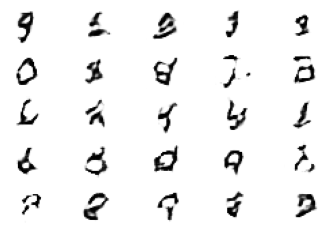

In [15]:
# test model in 10th epoch
from keras.models import load_model

gan1 = load_model('generator_model_010.h5')
latent_points = generate_latent_points(100, 25)

generated_images_1 = gan1.predict(latent_points)

show_generation(generated_images_1, 5)


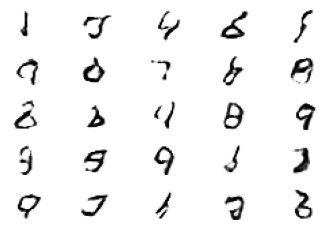

In [17]:
# test model in 20th epoch

gan1 = load_model('generator_model_020.h5')
latent_points = generate_latent_points(100, 25)

generated_images_2 = gan1.predict(latent_points)

show_generation(generated_images_2, 5)

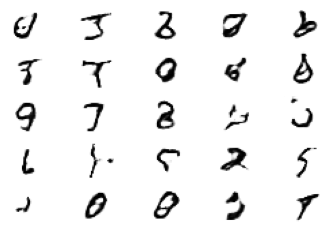

In [18]:
# test model in 30th epoch

gan1 = load_model('generator_model_030.h5')
latent_points = generate_latent_points(100, 25)

generated_images_3 = gan1.predict(latent_points)

show_generation(generated_images_3, 5)

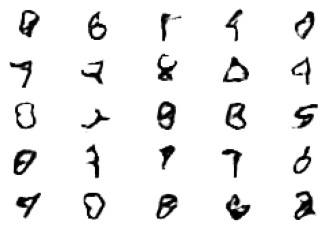

In [19]:
# test model in 40th epoch

gan1 = load_model('generator_model_040.h5')
latent_points = generate_latent_points(100, 25)

generated_images_4 = gan1.predict(latent_points)

show_generation(generated_images_4, 5)

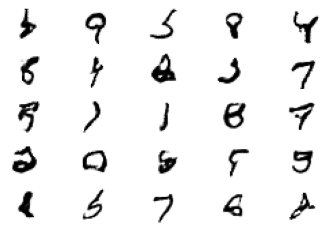

In [23]:
# test model in 100th epoch

gan1 = load_model('generator_model_100.h5')
latent_points = generate_latent_points(100, 25)

generated_images_10 = gan1.predict(latent_points)

show_generation(generated_images_10, 5)

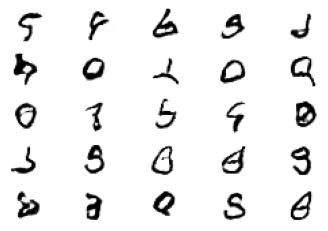

In [22]:
# test model in 90th epoch

gan1 = load_model('generator_model_090.h5')
latent_points = generate_latent_points(100, 25)

generated_images_9 = gan1.predict(latent_points)

show_generation(generated_images_9, 5)